## 🔍 Preguntas

## 1.1 Univariante (Google Returns)

- **¿Cómo se comporta la serie de retornos?**  
  - Tendencias a largo plazo  
  - Volatilidad  
  - Autocorrelación  

- **¿Hay estacionalidad o patrones recurrentes?**  
  - Efecto día de la semana  
  - Efecto mes del año  
  - Otros efectos de calendario  

- **¿Existen saltos (jumps) o outliers marcados?**  
  - Impacto de eventos corporativos  
  - Anuncios de resultados (“earnings”)  
  - Crisis de mercado  

- **¿Cómo varía la distribución de retornos en distintos subperíodos?**  
  - Pruebas de cambio de varianza (heterocedasticidad)  
  - Comparación de medias y cuantiles por intervalo  

## 1.2 Multivariante (Revenue, Net Income, R&D, EBITDA vs. Returns)

- **¿Cuál es la correlación entre cada variable financiera y los retornos de GOOG?**  
  - Correlación simple y cruzada  
  - Análisis de lags (retrasos)  

- **¿Alguna métrica financiera anticipa movimientos del precio?**  
  - Pruebas de causalidad de Granger  

- **¿Cómo evolucionan conjuntamente estas series?**  
  - Análisis de componentes principales (PCA)  
  - Clustering de fases de comportamiento financiero  

## 1.3 Panel (Google, Microsoft, Apple)

- **¿Hay co‐movimientos en los retornos de las tres empresas?**  
  - Correlación dinámica  
  - Pruebas de cointegración  

- **¿Se comportan igual en crisis (p. ej. marzo 2020)?**  
  - Comparación de volatilidad  
  - Análisis de drawdowns  

- **¿Existen leads/lags entre ellas?**  
  - Cross‐correlation functions  
  - Identificación de efectos adelantados

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 19.5 MB/s eta 0:00:00


In [ ]:
# ======================= LIBRERÍAS NECESARIAS =======================

# Core Python
import numpy as np
import pandas as pd
import warnings
from warnings import simplefilter

# Visualización
import matplotlib.pyplot as plt

# Modelos ARIMA/SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression

# Diagnóstico de residuos
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import jarque_bera, kurtosis, normaltest, t
import statsmodels.api as sm
from scipy.stats import t, jarque_bera
from arch import arch_model

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer

# Paralelización
from joblib import Parallel, delayed

# Progreso visual
from tqdm import tqdm

# Utilidades adicionales
from itertools import product

# Scaler
from sklearn.preprocessing import StandardScaler


# Dataset

Después de cargar el dataset con pandas, convierto la columna de fechas al formato que permite trabajar correctamente con series temporales.

Finalmente, asigno la fecha como índice, lo cual es importante porque muchos modelos de series temporales en Python requieren que las fechas estén en el índice para poder procesar correctamente los datos cronológicos.


In [ ]:
# Cargamos el archivo Excel que contiene los datos
df = pd.read_excel("/content/sample_data/df_uni_multi_google_2015_2025_1.xlsx")

# Convertimos la columna 'Date' al formato de fecha y hora de pandas
df["Date"] = pd.to_datetime(df["Date"])

# Establecemos la columna 'Date' como índice del DataFrame
df.set_index("Date", inplace=True)


## Estructura

En este apartado, realizo una revisión rápida de los datos.

1.   Primero verifico la estructura general: qué variables tengo, qué tipo de datos son y si hay valores nulos.


2.   Luego obtengo estadísticas descriptivas básicas como la media, desviación estándar, mínimos y máximos de cada variable.

3. Por último, consulto las fechas inicial y final para confirmar el rango temporal completo de mi serie.





In [ ]:
# Imprimimos la estructura general del DataFrame: columnas, tipos de datos y valores nulos
print("Estructura del DataFrame:\n")
print(df.info())

# Mostramos un resumen estadístico básico de todas las columnas numéricas
print("\n\nResumen estadístico:\n")
display(df.describe())

# Mostramos la primera fecha disponible en la serie temporal
print(f"\n\nPrimer día de la serie temporal : {df.index.min()}")

# Mostramos la última fecha disponible en la serie temporal
print(f"Último día de la serie temporal : {df.index.max()}")


Estructura del DataFrame:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2532 entries, 2015-05-26 to 2025-05-29
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   GOOGL Open               2519 non-null   float64
 1   GOOGL Low                2519 non-null   float64
 2   GOOGL High               2519 non-null   float64
 3   GOOGL Close              2519 non-null   float64
 4   GOOGL Adj. Close         2519 non-null   float64
 5   GOOGL EBITDA (FQ)        40 non-null     float64
 6   GOOGL Total Debt (FQ)    40 non-null     float64
 7   GOOGL Revenues (FQ)      40 non-null     float64
 8   GOOGL R&D Expenses (FQ)  40 non-null     float64
dtypes: float64(9)
memory usage: 197.8 KB
None


Resumen estadístico:



,GOOGL Open,GOOGL Low,GOOGL High,GOOGL Close,GOOGL Adj. Close,GOOGL EBITDA (FQ),GOOGL Total Debt (FQ),GOOGL Revenues (FQ),GOOGL R&D Expenses (FQ)
count,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01
mean,88.061044,87.137125,89.021423,88.468019,88.095857,1.673450e+10,1.796725e+10,5.070500e+10,7.317250e+09
std,45.579559,45.073400,46.121298,45.718045,45.590741,8.981378e+09,1.105139e+10,2.418121e+10,3.160075e+09
min,26.983493,26.814332,27.073065,27.002000,26.873519,5.960000e+09,3.940000e+09,1.773000e+10,2.790000e+09
25%,51.060880,50.154086,51.732917,51.263500,51.019578,9.600000e+09,6.027500e+09,3.030500e+10,4.285000e+09
50%,71.791767,71.048819,72.302819,72.115500,71.772360,1.260000e+10,1.704000e+10,4.362000e+10,6.870000e+09
75%,128.107524,126.729114,129.716830,128.507500,127.896035,2.399500e+10,2.853250e+10,7.099250e+10,1.027000e+10
max,203.156030,202.576697,206.811820,206.380000,206.142591,3.697000e+10,3.045000e+10,9.647000e+10,1.356000e+10




Primer día de la serie temporal : 2015-05-26 00:00:00
Último día de la serie temporal : 2025-05-29 00:00:00


## Valores Nulos

En este bloque ajusto las variables financieras cuando faltan datos de cierre diario de Google.

A veces los reportes financieros trimestrales se publican en días en los que el mercado está cerrado, por lo que no hay datos de apertura ni de cierre (ambos son NaN). **Para manejar correctamente estos casos, identifico los días sin cierre que tienen datos de report trimestral, y desplazo esos valores financieros al día siguiente, eliminando luego la fila original para evitar duplicados.**

Así me aseguro de que el dataset quede limpio, con cada dato financiero correctamente alineado al primer día hábil disponible.

In [ ]:
# Lista de columnas financieras trimestrales
financial_cols = [
    "GOOGL EBITDA (FQ)",
    "GOOGL Total Debt (FQ)",
    "GOOGL Revenues (FQ)",
    "GOOGL R&D Expenses (FQ)"
]

# Creamos una máscara booleana donde 'GOOGL Close' es NaN
mask_nan_close = df["GOOGL Close"].isna()

# Ajustamos los valores de las columnas financieras cuando falta el cierre
for col in financial_cols:
    # Desplazamos los valores hacia adelante en las filas donde el siguiente 'GOOGL Close' es NaN
    df.loc[mask_nan_close.shift(-1, fill_value=False), col] = df.loc[mask_nan_close, col].values
    # Limpiamos el valor original para evitar duplicados
    df.loc[mask_nan_close, col] = np.nan

# Rellenado hacia adelante de las columnas exógenas (desactivado por ahora)
# df[financial_cols] = df[financial_cols].ffill()

# Eliminamos las filas donde 'GOOGL Close' es NaN
df = df[df["GOOGL Close"].notna()].copy()

# Imprimimos el DataFrame resultante
print(df)


            GOOGL Open   GOOGL Low  GOOGL High  GOOGL Close  GOOGL Adj. Close  \
Date                                                                            
2015-05-26   27.497536   27.019322   27.534882      27.3595         27.229318   
2015-05-27   27.303463   27.199028   27.632391      27.7125         27.580638   
2015-05-28   27.557748   27.408959   27.655779      27.7090         27.577155   
2015-05-29   27.528388   27.122329   27.565212      27.2660         27.136263   
2015-06-01   27.305952   27.049677   27.397514      27.4605         27.329837   
...                ...         ...         ...          ...               ...   
2025-05-22  171.850000  170.710000  176.770000     170.8700        170.870000   
2025-05-23  169.055000  167.890000  169.960000     168.4700        168.470000   
2025-05-27  170.160000  170.000000  173.170000     172.9000        172.900000   
2025-05-28  172.360000  172.360000  172.360000     172.3600        172.360000   
2025-05-29  171.860000  171.

Confirmamos que no tenemos valores nulos en las columnas de datos diarios (las columnas con los datos financieros trimestrales se manejaran en los apartados siguientes):

In [ ]:
print("Estructura del DataFrame:\n")
print(df.info())

Estructura del DataFrame:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2519 entries, 2015-05-26 to 2025-05-29
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   GOOGL Open               2519 non-null   float64
 1   GOOGL Low                2519 non-null   float64
 2   GOOGL High               2519 non-null   float64
 3   GOOGL Close              2519 non-null   float64
 4   GOOGL Adj. Close         2519 non-null   float64
 5   GOOGL EBITDA (FQ)        40 non-null     float64
 6   GOOGL Total Debt (FQ)    40 non-null     float64
 7   GOOGL Revenues (FQ)      40 non-null     float64
 8   GOOGL R&D Expenses (FQ)  40 non-null     float64
dtypes: float64(9)
memory usage: 196.8 KB
None


# 📊 Análisis Exploratoria de Acciones de Google (GOOG)

## Variable objetivo




### 🧩 Definiciones clave

- **Precio del activo ($P_t$):**  
  Es el valor absoluto del activo en un momento dado.

- **Retorno simple ($R_t$):**  
  Es el cambio porcentual entre dos días consecutivos:

  $$
  R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1
  $$

- **Retorno logarítmico ($r_t$):**  
  Es el logaritmo natural del cociente entre dos precios consecutivos:

  $$
  r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
  $$

---

### ❌ **Precios**

- Los **precios no son estacionarios** → tienden a tener tendencias o rupturas.
- No permiten comparar distintos activos fácilmente debido a escalas distintas.
- Dificultan el modelado estadístico directo (por ejemplo, con ARIMA o VAR).

---

### ❌ **Retornos simples**

- No son **aditivos en el tiempo** → no se pueden sumar para obtener el retorno total de varios periodos.
- Son menos adecuados para técnicas estadísticas avanzadas (como GARCH, VAR).
- No se comportan bien con grandes caídas o subidas → asimetría.

---

### ✅ **Log-returns**

- Son **más simétricos** y tienen una distribución más cercana a la normal.
- Son **aditivos en el tiempo**:  
  
$$
r_{\text{total}} = r_1 + r_2 + \cdots + r_n
$$


- Son más apropiados para modelos econométricos y financieros continuos (ej: modelos de Black-Scholes).
- Permiten comparar activos en diferentes escalas y horizontes temporales.


Aquí calculo los rendimientos diarios de Google.

Primero obtengo el rendimiento porcentual, que mide el cambio relativo diario del precio ajustado. Después calculo el rendimiento logarítmico, que transforma los cambios porcentuales en logaritmos; esta medida es muy común en finanzas porque permite trabajar con propiedades estadísticas más estables y es aditiva en el tiempo.


In [ ]:
# Cálculo de los rendimientos y de los rendimientos logarítmicos
df["Return"] = df["GOOGL Adj. Close"].pct_change()  # Rendimiento porcentual diario
df["LogReturn"] = np.log(df["GOOGL Adj. Close"] / df["GOOGL Adj. Close"].shift(1))  # Rendimiento logarítmico diario

# Mostramos el DataFrame actualizado
df


,GOOGL Open,GOOGL Low,GOOGL High,GOOGL Close,GOOGL Adj. Close,GOOGL EBITDA (FQ),GOOGL Total Debt (FQ),GOOGL Revenues (FQ),GOOGL R&D Expenses (FQ),Return,LogReturn
Date,,,,,,,,,,,
2015-05-26,27.497536,27.019322,27.534882,27.3595,27.229318,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-27,27.303463,27.199028,27.632391,27.7125,27.580638,NaN,NaN,NaN,NaN,0.012902,0.012820
2015-05-28,27.557748,27.408959,27.655779,27.7090,27.577155,NaN,NaN,NaN,NaN,-0.000126,-0.000126
2015-05-29,27.528388,27.122329,27.565212,27.2660,27.136263,NaN,NaN,NaN,NaN,-0.015988,-0.016117
2015-06-01,27.305952,27.049677,27.397514,27.4605,27.329837,NaN,NaN,NaN,NaN,0.007133,0.007108
...,...,...,...,...,...,...,...,...,...,...,...
2025-05-22,171.850000,170.710000,176.770000,170.8700,170.870000,NaN,NaN,NaN,NaN,0.013704,0.013611
2025-05-23,169.055000,167.890000,169.960000,168.4700,168.470000,NaN,NaN,NaN,NaN,-0.014046,-0.014145
2025-05-27,170.160000,170.000000,173.170000,172.9000,172.900000,NaN,NaN,NaN,NaN,0.026295,0.025956


### 📈 Análisis general de las series temporales de precio de cierre de GOOGL, Return y LogReturn


Aquí visualizo cómo ha evolucionado el precio de cierre de Google a lo largo del tiempo. El gráfico me permite ver de forma rápida si ha habido tendencias, caídas o periodos de alta variabilidad.

Aunque solo ploteo el precio de cierre, este tipo de representación es fundamental como primer paso exploratorio antes de aplicar modelos cuantitativos, porque puedo detectar posibles rupturas estructurales, estacionalidades o anomalías que influirán en el análisis posterior.

<ipython-input-12-348707055>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


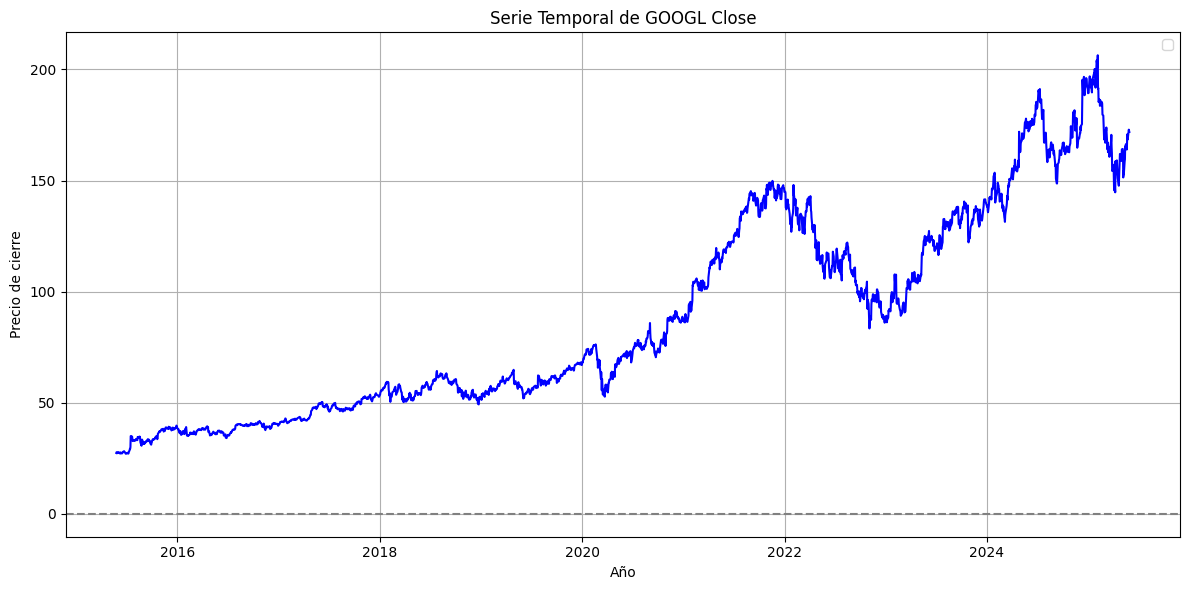

<Figure size 640x480 with 0 Axes>

In [ ]:
# Gráfico de la serie temporal para el precio de cierre, los retornos y los log-retornos
plt.figure(figsize=(12, 6))

# Dibujamos el precio de cierre diario de GOOGL
plt.plot(df.index, df["GOOGL Close"], color="blue")

# Línea horizontal en cero (aunque aquí no afecta mucho porque es el precio)
plt.axhline(0, color='gray', linestyle='--')

# Configuramos título y etiquetas
plt.title("Serie Temporal de GOOGL Close")
plt.xlabel("Año")
plt.ylabel("Precio de cierre")

# Mostramos la leyenda (aunque en este caso está vacía)
plt.legend()

# Mostramos la cuadrícula para facilitar la lectura del gráfico
plt.grid(True)

# Ajustamos el layout para que no se solapen los elementos
plt.tight_layout()

# Mostramos el gráfico
plt.show()

# (Estas dos líneas finales son redundantes, pero no afectan la ejecución)
plt.tight_layout()
plt.show()



El gráfico muestra la evolución del **precio de cierre diario de GOOGL** en el periodo 2015–2025.

🔹 **Tendencia:**

A lo largo del periodo, se observa una **tendencia claramente creciente**, especialmente acentuada entre 2020 y 2021, donde se registra un fuerte impulso alcista.

Este comportamiento refleja un crecimiento sostenido en el valor de la acción, coherente con la expansión del sector tecnológico en esos años.

🔹 **Volatilidad:**

A partir de 2022 se observa un **incremento en la volatilidad**, con oscilaciones más marcadas y frecuentes correcciones. Esto podría estar asociado a cambios macroeconómicos globales, subidas de tipos de interés o incertidumbre post-COVID.

🔹 **Estacionalidad:**

No se aprecia una estacionalidad clara o recurrente a nivel visual. Aunque hay ciclos de crecimiento y corrección, no parecen estar ligados a patrones estacionales evidentes.


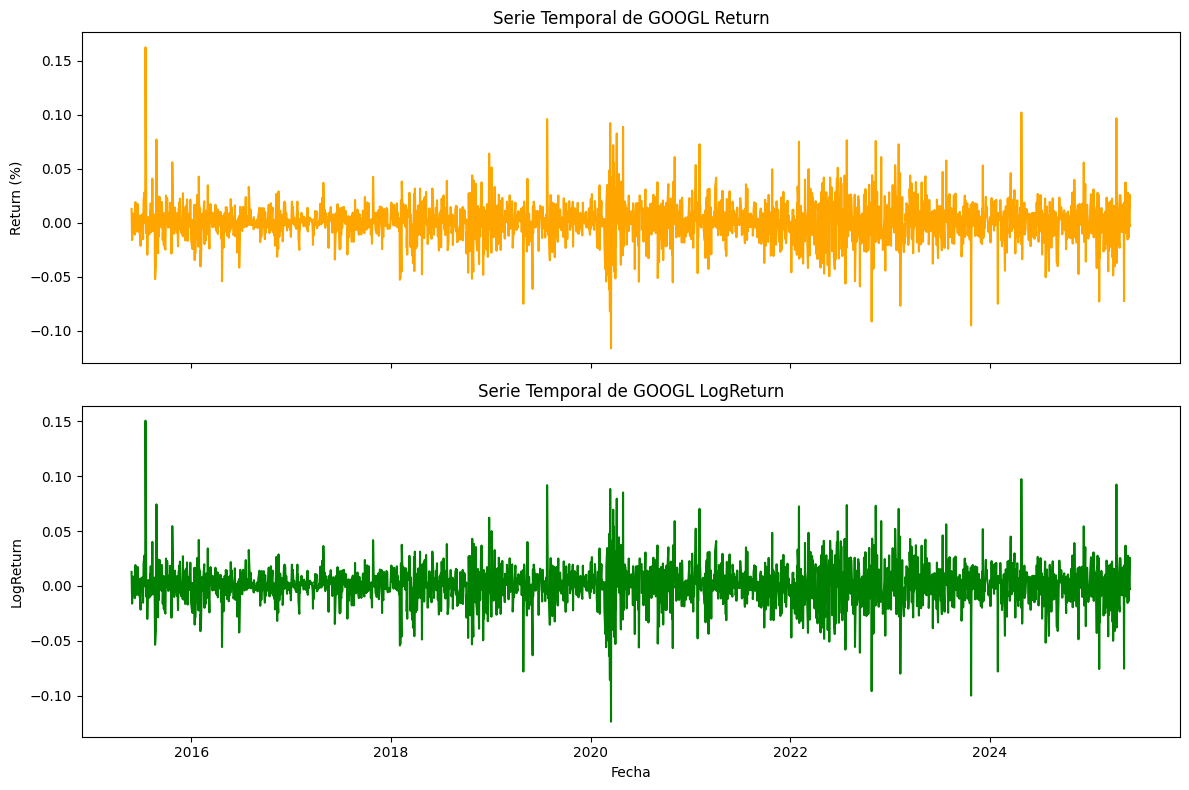

In [ ]:
# Crear figura y ejes
fig, axes = plt.subplots(2, figsize=(12, 8), sharex=True)

# Gráfico para Return
axes[0].plot(df.index, df['Return'], color='orange')
axes[0].set_title('Serie Temporal de GOOGL Return')
axes[0].set_ylabel('Return (%)')

# Gráfico para LogReturn
axes[1].plot(df.index, df['LogReturn'], color='green')
axes[1].set_title('Serie Temporal de GOOGL LogReturn')
axes[1].set_ylabel('LogReturn')
axes[1].set_xlabel('Fecha')

# Ajustar espacio
plt.tight_layout()
plt.show()


Los gráficos de Return y LogReturn de GOOGL entre 2015 y 2025 muestran un comportamiento típico de retornos financieros: ambos oscilan alrededor de cero, sin una tendencia clara, pero con episodios de fuerte volatilidad.

Se observan picos destacados en momentos concretos —como en 2020 y 2022— que reflejan periodos de inestabilidad en el mercado (por ejemplo, la pandemia o tensiones macroeconómicas posteriores).

**Aunque ambos reflejan la misma dinámica, el log-return presenta una distribución algo más simétrica, lo que lo hace más adecuado para ciertos modelos estadísticos.** La volatilidad no es constante a lo largo del tiempo: existen fases más tranquilas y otras de alta dispersión de los retornos, lo que sugiere presencia de heterocedasticidad (característica habitual en series financieras).

En conjunto, ambas series capturan las variaciones diarias del precio pero desde una perspectiva estacionaria, mucho más apropiada para análisis de riesgo, predicción o modelización estadística avanzada.

----

Para poder observar de forma más clara la volatilidad, se ha calculado la **volatilidad móvil a 30 días** de los LogReturn.



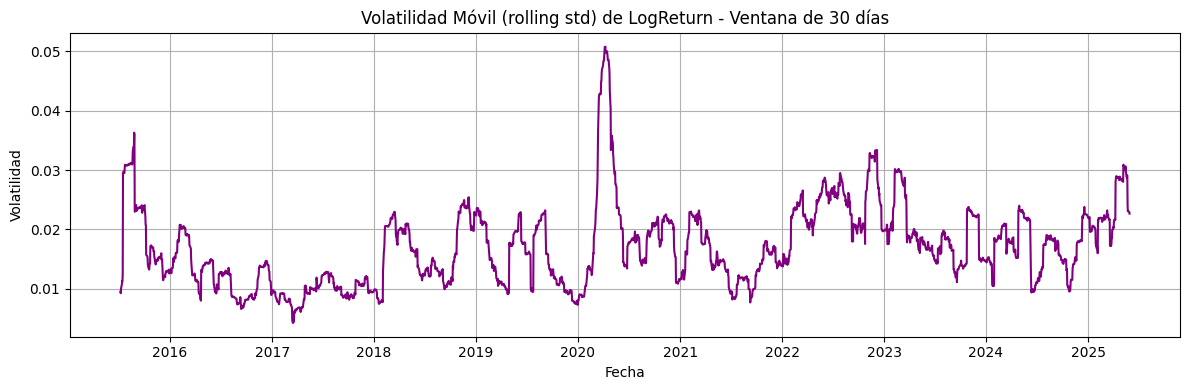

In [ ]:
# Calculamos la volatilidad móvil usando la desviación estándar de los log-retornos en una ventana de 30 días
df["Volatility30"] = df["LogReturn"].rolling(30).std()

# Graficamos la serie temporal de la volatilidad móvil
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["Volatility30"], color='purple')

# Título y etiquetas del gráfico
plt.title("Volatilidad Móvil (rolling std) de LogReturn - Ventana de 30 días")
plt.ylabel("Volatilidad")
plt.xlabel("Fecha")

# Mostramos la cuadrícula
plt.grid(True)

# Ajustamos el diseño del gráfico
plt.tight_layout()

# Mostramos el gráfico
plt.show()


El gráfico generado muestra un **pico máximo en 2020**, en plena pandemia por COVID-19, donde la volatilidad supera el 5%. Posteriormente, se observan otros periodos de elevada volatilidad (especialmente en 2022–2023), lo que confirma que la serie presenta **heterocedasticidad**, es decir, varianza no constante a lo largo del tiempo.

----


Aquí comparo directamente los dos tipos de retorno: porcentual y logarítmico.

**Aunque en teoría son muy parecidos cuando los cambios de precio son pequeños, con el tiempo pueden acumular diferencias significativas.**

Por eso, calculo primero la diferencia diaria entre ambos y luego sumo estas diferencias a lo largo del tiempo. Al graficar la diferencia acumulada puedo verificar si, en el horizonte temporal que analizo, estas diferencias son relevantes o despreciables para mis modelos.



<ipython-input-15-2365003135>:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


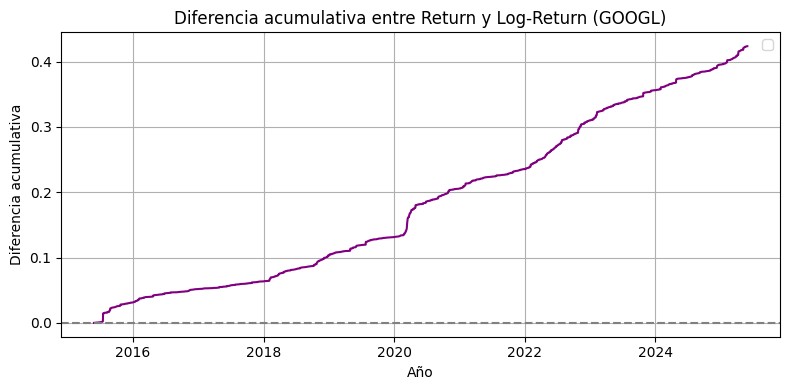

In [ ]:
# Calculamos la diferencia diaria entre el retorno porcentual y el log-retorno
df["Diff"] = df["Return"] - df["LogReturn"]

# Calculamos la suma acumulada de estas diferencias a lo largo del tiempo
df["CumDiff"] = df["Diff"].cumsum()

# Graficamos la diferencia acumulativa
plt.figure(figsize=(8, 4))
plt.plot(df.index, df["CumDiff"], color="purple")

# Línea de referencia en cero para facilitar la interpretación visual
plt.axhline(0, color='gray', linestyle='--')

# Título y etiquetas del gráfico
plt.title("Diferencia acumulativa entre Return y Log-Return (GOOGL)")
plt.xlabel("Año")
plt.ylabel("Diferencia acumulativa")

# Mostramos la leyenda (aunque aquí no hay etiquetas activas)
plt.legend()

# Mostramos la cuadrícula
plt.grid(True)

# Ajustamos el diseño del gráfico
plt.tight_layout()

# Mostramos el gráfico
plt.show()


**📌 Interpretación del gráfico:**

Este gráfico muestra la diferencia acumulada entre los **retornos simples** y los **retornos logarítmicos (LogReturn)** del precio ajustado de GOOGL entre 2015 y 2025.

Este gráfico muestra cómo, aunque día a día las diferencias son mínimas, con el paso del tiempo la diferencia acumulada se **amplifica progresivamente**, lo que evidencia que:
- Los retornos simples **sobreestiman el rendimiento acumulado total** (aprox. del 42%).
- Los LogReturn proporcionan una **medida más precisa y coherente del rendimiento financiero a largo plazo**.



✅ **Conclusión**

La variable LogReturn ofrece una representación más estable, simétrica y estadísticamente adecuada del comportamiento del precio de la acción.

Además, la volatilidad móvil demuestra que la serie presenta **periodos de alta inestabilidad**, lo que justifica el uso de modelos como **ARIMA con variables dummy para outliers**, o **modelos GARCH**, que capturan mejor la dinámica de la varianza.

Este enfoque permite mejorar la calidad predictiva y la interpretación de los modelos aplicados a datos financieros.


## Outliers

Para la detección de valores atípicos en la serie de LogReturn de GOOGL, se ha utilizado el algoritmo **Isolation Forest**, una técnica no supervisada basada en árboles de decisión que permite identificar observaciones anómalas sin necesidad de asumir una distribución previa de los datos.

Esta técnica es especialmente adecuada en contextos financieros, donde los outliers pueden corresponder a eventos de mercado excepcionales (crisis, anuncios corporativos, etc.) que alteran temporalmente la dinámica de la serie.

A través del gráfico generado, se visualizan los días detectados como outliers bajo distintos niveles de sensibilidad del modelo (**contamination**), lo que permite evaluar el impacto de incluir o excluir estas observaciones en los modelos de predicción.

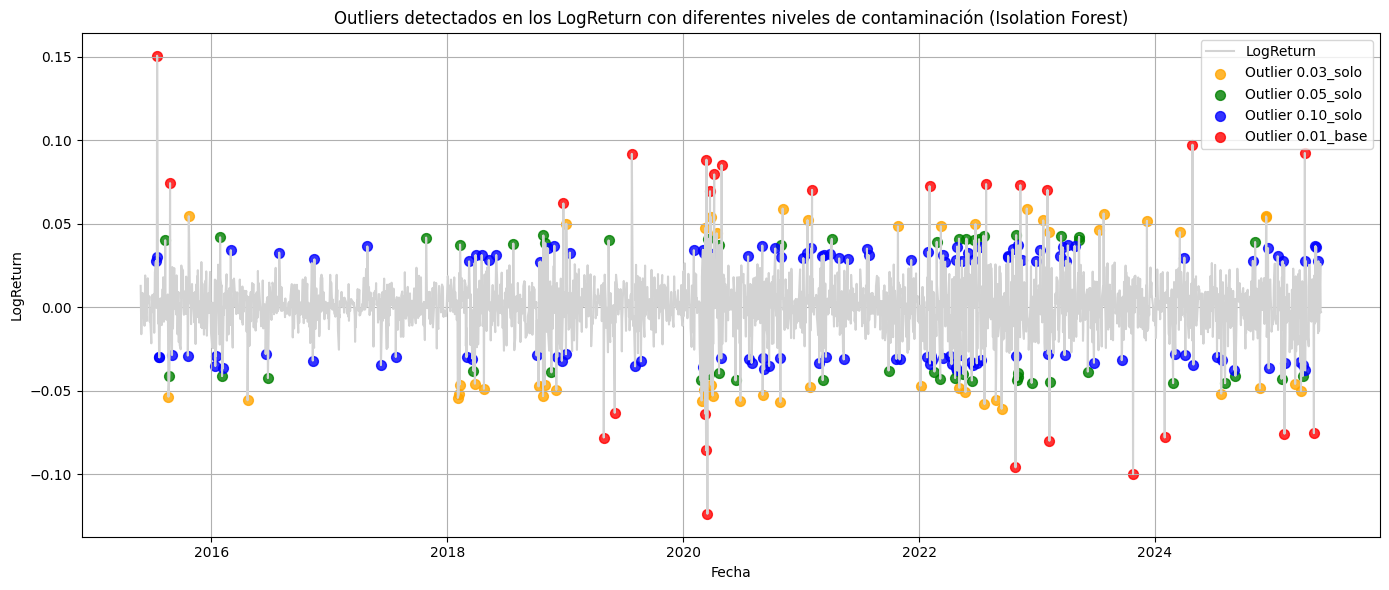

In [ ]:
from sklearn.ensemble import IsolationForest

# Definimos los diferentes niveles de contaminación a comparar
niveles_contaminacion = [0.01, 0.03, 0.05, 0.10]
outliers_por_nivel = {}

# Aplicamos Isolation Forest sobre los log-retornos para cada nivel
for contaminacion in niveles_contaminacion:
    iso_forest = IsolationForest(contamination=contaminacion, random_state=42)
    # Eliminamos los NaN antes de aplicar el modelo
    logreturns_validos = df['LogReturn'].dropna().values.reshape(-1, 1)
    etiquetas = iso_forest.fit_predict(logreturns_validos)
    indices_outliers = set(df['LogReturn'].dropna().index[etiquetas == -1])
    outliers_por_nivel[contaminacion] = indices_outliers

# Calculamos los outliers que aparecen solo al aumentar el nivel de contaminación
diferencia_outliers = {
    '0.03_solo': outliers_por_nivel[0.03] - outliers_por_nivel[0.01],
    '0.05_solo': outliers_por_nivel[0.05] - outliers_por_nivel[0.03],
    '0.10_solo': outliers_por_nivel[0.10] - outliers_por_nivel[0.05],
    '0.01_base': outliers_por_nivel[0.01]  # los más extremos
}

# Creación del gráfico
plt.figure(figsize=(14, 6))

# Serie completa de log-retornos en gris claro
plt.plot(df.index, df['LogReturn'], color='lightgray', label='LogReturn')

# Colores para cada grupo de outliers
colores = {
    '0.01_base': 'red',
    '0.03_solo': 'orange',
    '0.05_solo': 'green',
    '0.10_solo': 'blue'
}

# Dibujamos los outliers para cada grupo
for etiqueta, indices in diferencia_outliers.items():
    subconjunto = df.loc[list(indices)]
    plt.scatter(subconjunto.index, subconjunto['LogReturn'], label=f'Outlier {etiqueta}', color=colores[etiqueta], s=50, alpha=0.8)

# Títulos y formato
plt.title("Outliers detectados en los LogReturn con diferentes niveles de contaminación (Isolation Forest)")
plt.xlabel("Fecha")
plt.ylabel("LogReturn")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Con el objetivo de mejorar la capacidad explicativa y predictiva del modelo de serie temporal, se ha creado una **variable dummy binaria** que toma valor 1 en los días identificados como outliers por el modelo Isolation Forest (con nivel de contaminación 0.01) y 0 en el resto.

Esta dummy se incorporará como **variable exógena** para capturar el efecto puntual de shocks extremos sobre el comportamiento de los retornos.

De esta forma, **no se eliminan los datos atípicos —lo que podría distorsionar la estructura temporal—, sino que se modela explícitamente su impacto, permitiendo una mejor estimación de los parámetros del modelo y una reducción del error de predicción.**


In [ ]:
# Outlier 0.01 (i più estremi)
outlier_dates = outliers_por_nivel[0.10]  # o [0.03] se vuoi testare

# Crea la dummy nel DataFrame
df["OutlierDummy"] = 0
df.loc[df.index.isin(outlier_dates), "OutlierDummy"] = 1

df

,GOOGL Open,GOOGL Low,GOOGL High,GOOGL Close,GOOGL Adj. Close,GOOGL EBITDA (FQ),GOOGL Total Debt (FQ),GOOGL Revenues (FQ),GOOGL R&D Expenses (FQ),Return,LogReturn,Volatility30,Diff,CumDiff,OutlierDummy
Date,,,,,,,,,,,,,,,
2015-05-26,27.497536,27.019322,27.534882,27.3595,27.229318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-05-27,27.303463,27.199028,27.632391,27.7125,27.580638,NaN,NaN,NaN,NaN,0.012902,0.012820,NaN,8.252536e-05,0.000083,0
2015-05-28,27.557748,27.408959,27.655779,27.7090,27.577155,NaN,NaN,NaN,NaN,-0.000126,-0.000126,NaN,7.976112e-09,0.000083,0
2015-05-29,27.528388,27.122329,27.565212,27.2660,27.136263,NaN,NaN,NaN,NaN,-0.015988,-0.016117,NaN,1.291801e-04,0.000212,0
2015-06-01,27.305952,27.049677,27.397514,27.4605,27.329837,NaN,NaN,NaN,NaN,0.007133,0.007108,NaN,2.532253e-05,0.000237,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-22,171.850000,170.710000,176.770000,170.8700,170.870000,NaN,NaN,NaN,NaN,0.013704,0.013611,0.024048,9.305497e-05,0.423024,0
2025-05-23,169.055000,167.890000,169.960000,168.4700,168.470000,NaN,NaN,NaN,NaN,-0.014046,-0.014145,0.023048,9.957528e-05,0.423124,0
2025-05-27,170.160000,170.000000,173.170000,172.9000,172.900000,NaN,NaN,NaN,NaN,0.026295,0.025956,0.022980,3.397826e-04,0.423464,0


In [ ]:
n_obs_anomalas = df["OutlierDummy"].sum()

print(f"El número de valores anomalos es de {n_obs_anomalas} sobre un total de {len(df)} observaciones.")

El número de valores anomalos es de 252 sobre un total de 2519 observaciones.


# 📊 Análisis Exploratoria de Acciones de Google (GOOG)


## Decomposición de la serie temporal


La descomposición de una serie temporal tiene como objetivo identificar y separar componentes estructurales como la tendencia, la estacionalidad y los residuos.

Sin embargo, en el caso de una serie de la variable observada, **LogReturn**, esta técnica pierde relevancia, ya que sus valores son por naturaleza **estacionarios**: representan las variaciones relativas entre precios y no muestran tendencias sistemáticas acumuladas.

Además, en datos financieros como los retornos de una acción, no suele existir una **estacionalidad estructurada clara** que justifique dicha descomposición.

Por tanto, aunque el proceso de descomposición puede realizarse técnicamente, **no aporta información significativa** para el análisis de esta serie y resulta más apropiado emplear modelos diseñados para capturar la dinámica de la volatilidad, como los modelos GARCH.


##Prueba de estacionariedad: ADF test

El test de Dickey-Fuller aumentado (ADF) es una prueba estadística que se utiliza para comprobar si una serie temporal es **estacionaria**, es decir, si sus propiedades estadísticas (como la media y la varianza) se mantienen constantes en el tiempo.

Este aspecto es importante porque muchos **modelos como AR (AutoRegresivo), MA (Media Móvil), ARIMA o SARIMAX, etc, trabajan con series temporales estacionarias**.

El ADF la hipótesis nula se basa sobre que la serie **no es estacionaria**. Si el resultado del test devuelve un valor p menor que 0.05, podemos rechazar esta hipótesis y concluir que la serie **sí es estacionaria**, lo que valida su uso en modelos como ARIMA o GARCH.


In [ ]:
# Aplicamos el test ADF a la serie LogReturn
resultado_adf = adfuller(df['LogReturn'].dropna())

# Interpretación rápida
if resultado_adf[1] < 0.05:
    print("\n✅ La serie es estacionaria (se rechaza la hipótesis nula).")
else:
    print("\n❌ No se puede rechazar la hipótesis nula: la serie NO es estacionaria.")



✅ La serie es estacionaria (se rechaza la hipótesis nula).


De momento que la serie temporal es estacionaria, no necesitamos aplicar ningún tipo de diferenciación.

## Autocorrelación

En el análisis de series temporales, las funciones **ACF (Autocorrelation Function)** y **PACF (Partial Autocorrelation Function)** son herramientas fundamentales para entender cuánto los valores actuales son influenciados por los pasados.

- **ACF (Función de Autocorrelación)**: mide cómo de relacionado está el valor actual de la serie con sus propios valores pasados, considerando tanto las relaciones directas como indirectas. Por ejemplo, puede mostrar que el valor de hoy está correlacionado con el de hace 3 días, pero esa relación puede ser porque también está correlacionado con el de hace 1 y 2 días.

- **PACF (Función de Autocorrelación Parcial)**: mide solo la relación directa entre el valor actual y un valor en el pasado, eliminando la influencia de los lags intermedios. Es decir, nos dice si el retraso específico (por ejemplo, el de hace 3 días) aporta información nueva, una vez que ya hemos tenido en cuenta los retrasos anteriores.

Estas funciones son especialmente útiles para determinar los parámetros óptimos en modelos como **ARIMA**: la **ACF** ayuda a identificar el orden **q** (parte MA) y la **PACF** el orden **p** (parte AR).


| Gráfico   | Qué muestra                                      | Cómo interpretarlo en general                                                                 |
|-----------|--------------------------------------------------|------------------------------------------------------------------------------------------------|
| **ACF**   | Correlación entre la serie y sus propios rezagos | Si disminuye lentamente ⇒ la serie probablemente **no es estacionaria** ⇒ se recomienda una diferenciación (d > 0) |
| **PACF**  | Correlación neta con cada rezago, eliminando los efectos intermedios | Si aparece un pico claro en un lag específico ⇒ ese puede ser un buen valor para el parámetro **p** del modelo AR |


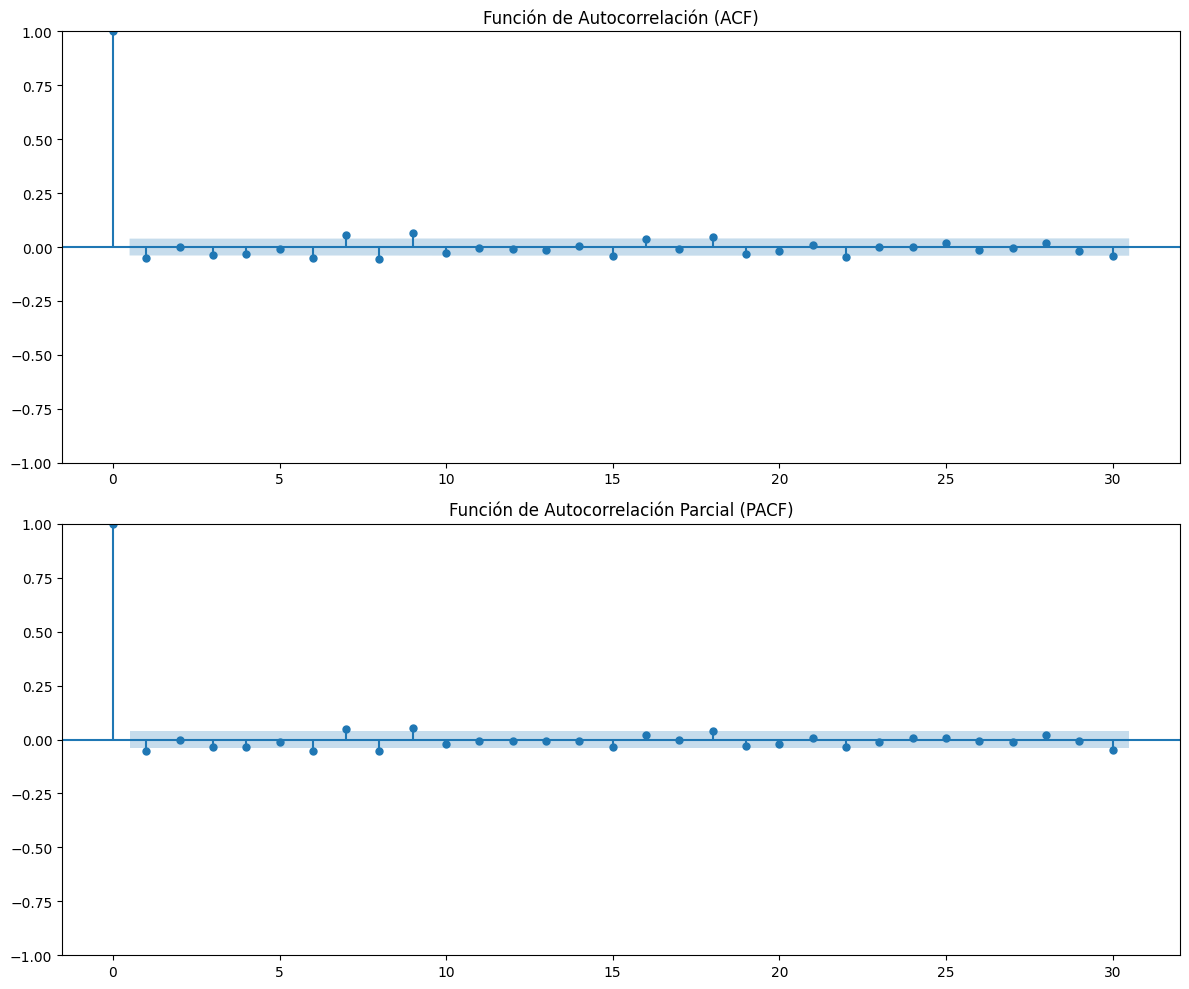

In [ ]:
# Asumiendo que tu DataFrame se llama df y contiene la columna 'LogReturn'
serie = df['LogReturn'].dropna()

# Crear una figura con dos subgráficos: ACF y PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico ACF
plot_acf(serie, ax=axes[0], lags=30, title="Función de Autocorrelación (ACF)")

# Gráfico PACF
plot_pacf(serie, ax=axes[1], lags=30, method='ywm', title="Función de Autocorrelación Parcial (PACF)")

plt.tight_layout()
plt.show()

Al analizar la Función de Autocorrelación (ACF) y la Función de Autocorrelación Parcial (PACF) de la serie de LogReturn de GOOGL, observamos lo siguiente:

- En la **ACF**, el lag 1 muestra un coeficiente claramente fuera del intervalo de confianza, y adicionalmente se aprecia otros valores significativos en el lag 8 y en el lag 9. Todos los demás rezagos caen rápidamente dentro del intervalo de confianza, lo que indica que, aparte de esos rezagos específicos (1, 8 y 9), no hay correlaciones notables en los demás retrasos temporales.
- En la **PACF**, igualmente los lags 1, 8 y 9 se encuentran fuera de la banda de significancia, mientras que el resto de los rezagos se mantiene dentro del intervalo de confianza.

Esto sugiere que existen dependencias lineales directas en el valor inmediatamente anterior (lag 1) y dependencias más debiles en los valores correspondientes a ocho y nueve periodos atrás.

Este patrón —pics destacados en los rezagos 1, 8 y 9, con autocorrelaciones en la mayoría de los otros lags cayendo rápidamente a valores no significativos— sugiere que la serie se comporta en gran medida como un **ruido blanco** o un **proceso autorregresivo de orden bajo con efectos esporádicos**.

En el contexto financiero, no es inusual que los retornos muestren dependencia casi aleatoria, aunque a veces aparezcan señales débiles en ciertos lags más alejados (como los lags 8 y 9 en este caso), posiblemente vinculadas a ciclos de mercado o a patrones transitorios localizados.  


## Smoothing


En el contexto de los log-return financieros diarios, no suele tener sentido aplicar técnicas de suavizado como medias móviles o suavizado exponencial.

Esto se debe a que los LogReturn ya representan una transformación de los precios que elimina tendencias acumuladas y suelen comportarse como ruido blanco o procesos sin una estructura clara.

Aplicar smoothing podría ocultar información relevante sobre eventos extremos o shocks de mercado, que son justamente los fenómenos más importantes a modelar en finanzas.


# 📊Analisis Univariada - GOOG

El análisis univariado tiene como objetivo estudiar cada variable de forma individual, sin considerar aún las relaciones con otras variables.

En este caso se ha realizado sobre variables relacionadas con los asset de Google, como su retorno logaritmico y otros indicadores técnicos derivados: momentum, volatilidad móvil, RSI, gaps de medias móviles (SMA).

Todo esto siempre para lograr el objetivo de modelar la serie para predecir sus valores diarios futuros.

## División del conjunto en train y test y en variables dependiente (X) e indipendiente (y)

 Divido la serie temporal en dos partes: 80% para entrenamiento y 20% para prueba, manteniendo el orden temporal.

 Después separo la variable objetivo, que es el retorno logaritmico, y una variable dummy que marca los posibles outliers.

 Este dummy lo usaré como variable exógena para ayudar al modelo a identificar días atípicos y evitar que distorsionen las predicciones.

In [ ]:

# Configurazione warning più selettiva
simplefilter(action='ignore', category=UserWarning)

train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Separazione variabili
y_train = train_data['LogReturn']
y_test = test_data['LogReturn']
X_train = train_data['OutlierDummy']  # Dummy outliers per il train
X_test = test_data['OutlierDummy']    # Dummy outliers per il test


print(f"✅ Train size: {len(y_train)}")
print(f"✅ Test size: {len(y_test)}")




✅ Train size: 2015
✅ Test size: 504


✅ RMSE del modelo naïve (correcto): 0.02363


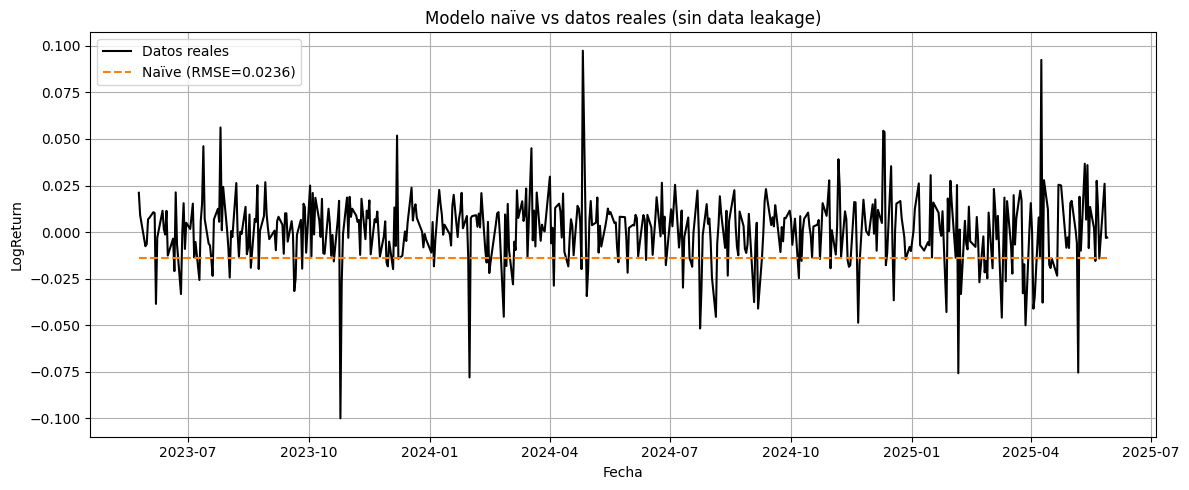

In [ ]:
# ---------- 2. Predicción naïve (SIN LEAKAGE) ----------
naive_pred = pd.Series(index=y_test.index)

# El primer valor de la predicción es igual al último valor del conjunto de entrenamiento
naive_pred.iloc[0] = y_train.iloc[-1]

# Predicción walk-forward: cada paso usa solo la predicción anterior (no usa datos futuros)
for i in range(1, len(y_test)):
    naive_pred.iloc[i] = naive_pred.iloc[i - 1]  # NO se usa y_test aquí (evitamos data leakage)

# ---------- 3. Cálculo del RMSE ----------
rmse_naive = np.sqrt(mean_squared_error(y_test, naive_pred))
print(f"✅ RMSE del modelo naïve (correcto): {rmse_naive:.5f}")

# ---------- 4. Gráfico ----------
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Datos reales', color='black')
plt.plot(y_test.index, naive_pred,
         label=f'Naïve (RMSE={rmse_naive:.4f})',
         color='tab:orange', linestyle='--')

plt.title("Modelo naïve vs datos reales (sin data leakage)")
plt.xlabel("Fecha")
plt.ylabel("LogReturn")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Naive

El modelo naïve es un enfoque simple para predecir series temporales, donde asumimos que el próximo valor será igual al último observado.

Aunque parece básico, **este modelo sirve como referencia clave:** si un modelo avanzado no supera al naïve, no aporta valor real. Además, evita el 'data leakage' porque no usa información futura.

Para no cometer data leakage, cada predicción depende solo de la predicción anterior, sin utilizar los valores reales futuros.

**Su simplicidad lo hace útil para comparar métodos complejos y detectar si merece la pena usarlos.**




✅ RMSE del modelo naïve (correcto): 0.02363


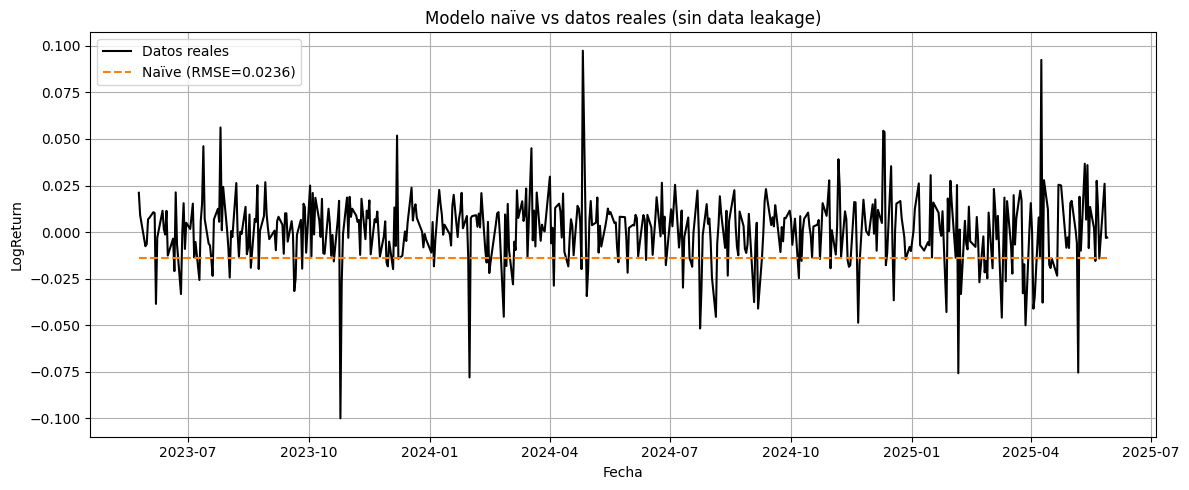

In [ ]:
# ---------- 2. Predicción naïve (SIN LEAKAGE) ----------
naive_pred = pd.Series(index=y_test.index)

# El primer valor de la predicción es igual al último valor observado en el conjunto de entrenamiento
naive_pred.iloc[0] = y_train.iloc[-1]

# Predicción en modo walk-forward: cada predicción usa solo la anterior
for i in range(1, len(y_test)):
    naive_pred.iloc[i] = naive_pred.iloc[i - 1]  # NO se usa y_test (evitamos data leakage)

# ---------- 3. Cálculo del RMSE ----------
rmse_naive = np.sqrt(mean_squared_error(y_test, naive_pred))
print(f"✅ RMSE del modelo naïve (correcto): {rmse_naive:.5f}")

# ---------- 4. Gráfico ----------
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Datos reales', color='black')
plt.plot(y_test.index, naive_pred,
         label=f'Naïve (RMSE={rmse_naive:.4f})',
         color='tab:orange', linestyle='--')
plt.title("Modelo naïve vs datos reales (sin data leakage)")
plt.xlabel("Fecha")
plt.ylabel("LogReturn")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


En el gráfico se observa que las predicciones del modelo naïve forman una línea plana. Esto ocurre porque, para cada paso del tiempo, el modelo siempre utiliza el último valor disponible del conjunto de entrenamiento (en este caso, el último log-return observado) y lo repite hacia el futuro. No considera tendencias, patrones ni información futura real (lo que evitaría el data leakage).

La línea plana refleja la hipótesis más conservadora, o sea **el futuro será idéntico al presente conocido**.

## Otras variables derivadas de la información sobre el asset

En este bloque calculo diferentes variables técnicas para enriquecer el modelo.

Todas las variables están laggeadas para evitar el uso de información futura (look-ahead).

- **Momentum:** mide la fuerza de la tendencia. Lo calculo como la media de los log-retornos recientes. Un momentum positivo indica tendencia alcista, mientras que un momentum negativo sugiere tendencia bajista.

- **Volatilidad:** refleja la variabilidad de los precios en un periodo. La calculo como la desviación estándar de los log-retornos en diferentes ventanas. Sirve para detectar momentos de mayor o menor riesgo.

- **RSI (Relative Strength Index):** es un indicador de sobrecompra o sobreventa. Si está cerca de 70 indica posible sobrecompra; si está cerca de 30, posible sobreventa. Lo calculo de forma manual usando las ganancias y pérdidas medias de los últimos 14 días.

- **SMA Gap (diferencia respecto a la media móvil):** mide cuánto se desvía el precio actual respecto a su media móvil pasada. Verifico que estas diferencias sean estacionarias mediante el test ADF, ya que es importante que las variables técnicas no tengan tendencias sistemáticas. Filtro solo aquellas que superan el test de estacionariedad en cuanto necesito que sean estacionarias para poderle aplicar el test de Granger sucesivamente.

- **Cruce de medias móviles (SMA Cross):** es una variable binaria que indica si la media móvil rápida (20 días) está por encima de la lenta (50 días), lo que suele interpretarse como señal de tendencia alcista.

- **Drawdown:** mide la caída desde el máximo reciente. Es útil para evaluar la magnitud de las correcciones dentro de la serie.

Estas variables me permiten capturar distintos aspectos del comportamiento de los precios: tendencia, volatilidad, niveles extremos y correcciones, lo cual en conjunto aporta información valiosa para alimentar los modelos predictivos.


In [ ]:
# ------------------------
# PASO 2: Variables técnicas (sin look-ahead)
# ------------------------
df_exog = df.copy()

# Momentum con lags (promedio móvil de los log-retornos pasados)
df_exog["Momentum_3"] = df["LogReturn"].shift(1).rolling(window=3).mean()
df_exog["Momentum_6"] = df["LogReturn"].shift(1).rolling(window=6).mean()
df_exog["Momentum_12"] = df["LogReturn"].shift(1).rolling(window=12).mean()

# Volatilidad con lags (desviación estándar de los log-retornos pasados)
df_exog["Volatility_3"] = df["LogReturn"].shift(1).rolling(window=3).std()
df_exog["Volatility_6"] = df["LogReturn"].shift(1).rolling(window=6).std()
df_exog["Volatility_12"] = df["LogReturn"].shift(1).rolling(window=12).std()

# RSI manual (laggeado 1 día para evitar uso de datos futuros)
delta = df["GOOGL Adj. Close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean().shift(1)
avg_loss = loss.rolling(window=14).mean().shift(1)
rs = avg_gain / avg_loss
df_exog["RSI_14"] = 100 - (100 / (1 + rs))

# SMA gap estacionarios (laggeados y filtrados con ADF)
from statsmodels.tsa.stattools import adfuller

sma_windows = [5, 20, 50]
for window in sma_windows:
    sma_col = f"SMA_{window}_lagged"
    gap_col = f"SMA_gap_{window}"

    # Calculamos la SMA laggeada (sin usar datos de t)
    df_exog[sma_col] = df["GOOGL Adj. Close"].shift(1).rolling(window=window).mean()

    # Calculamos el gap de la SMA sin look-ahead
    df_exog[gap_col] = df["GOOGL Adj. Close"].shift(1) - df_exog[sma_col]

    # Test de estacionariedad ADF
    serie = df_exog[gap_col].dropna()
    adf_pval = adfuller(serie, autolag='AIC')[1]

    if adf_pval >= 0.05:
        print(f"⚠️ {gap_col} NO estacionaria (ADF p={adf_pval:.5f}) → Eliminada")
        df_exog.drop(columns=[sma_col, gap_col], inplace=True)

# Cruce de SMAs (binaria, permanece sin cambios)
df_exog["SMA_Cross"] = (df_exog.get("SMA_20_lagged", 0) > df_exog.get("SMA_50_lagged", 0)).astype(int)

# Drawdown (laggeado)
df_exog["Drawdown"] = (df["GOOGL Adj. Close"].shift(1) / df["GOOGL Adj. Close"].cummax().shift(1)) - 1

# Mostramos las columnas finales generadas
print(df_exog.columns)


Index(['GOOGL Open', 'GOOGL Low', 'GOOGL High', 'GOOGL Close',
       'GOOGL Adj. Close', 'GOOGL EBITDA (FQ)', 'GOOGL Total Debt (FQ)',
       'GOOGL Revenues (FQ)', 'GOOGL R&D Expenses (FQ)', 'Return', 'LogReturn',
       'Volatility30', 'Diff', 'CumDiff', 'OutlierDummy', 'Momentum_3',
       'Momentum_6', 'Momentum_12', 'Volatility_3', 'Volatility_6',
       'Volatility_12', 'RSI_14', 'SMA_5_lagged', 'SMA_gap_5', 'SMA_20_lagged',
       'SMA_gap_20', 'SMA_50_lagged', 'SMA_gap_50', 'SMA_Cross', 'Drawdown'],
      dtype='object')


En este bloque integro los datos de volumen de Google con el resto de las variables exógenas y los dummies de outliers.

Después, aplico un forward fill únicamente a las variables financieras trimestrales y al volumen, ya que estos valores se mantienen constantes hasta el siguiente reporte oficial.

Finalmente, elimino posibles registros incompletos que todavía tengan valores faltantes en EBITDA, dejando el conjunto de datos listo y limpio para el análisis.



In [ ]:
google_volume = pd.read_excel("/content/sample_data/goog_volumes.xlsx")

# Convertimos la columna 'Date' al formato datetime
google_volume['Date'] = pd.to_datetime(google_volume['Date'])

# Establecemos 'Date' como índice del DataFrame
google_volume.set_index('Date', inplace=True)

# Combinamos las variables exógenas, el volumen y el dummy de outliers en un único DataFrame
df_merged = pd.concat([df_exog, google_volume, df[["OutlierDummy"]]], axis=1)

# Lista de columnas financieras y de volumen (datos trimestrales)
quarterly_cols = [
    "GOOGL EBITDA (FQ)",
    "GOOGL Total Debt (FQ)",
    "GOOGL Revenues (FQ)",
    "GOOGL R&D Expenses (FQ)",
    "GOOGL Volume"
]

# Aplicamos forward fill solo a las variables trimestrales para completar valores vacíos
df_merged = df_merged.sort_index()
df_merged[quarterly_cols] = df_merged[quarterly_cols].ffill()

# Eliminamos filas que siguen teniendo NaN en 'EBITDA' (caso extremo de registros incompletos)
df_merged.dropna(subset=["GOOGL EBITDA (FQ)"], inplace=True)

# Visualizamos el resultado final
#print(df_merged)


En este bloque evalúo si las variables exógenas tienen capacidad predictiva sobre los retornos de Google.

Primero, aplico el test de estacionariedad ADF a cada variable técnica, ya que la causalidad de Granger requiere trabajar con series estacionarias. Solo continúo con aquellas variables que superan el test.

Después, aplico el test de causalidad de Granger, que analiza si los valores pasados de cada variable exógena ayudan a explicar los log-retornos futuros.

Al final, ordeno los resultados según el p-valor más bajo de Granger para identificar las variables con mayor potencial predictivo.



## Test de Granger para elegir exogenas

El test de causalidad de Granger permite evaluar si los valores pasados de una variable exógena contienen información útil para predecir el comportamiento futuro de una variable dependiente, teniendo en cuenta su propia dinámica temporal.

A diferencia de los métodos clásicos de correlación como Pearson o Spearman, que miden simplemente la asociación entre dos variables en el mismo instante (sin considerar el orden temporal), el test de Granger está diseñado específicamente para series temporales y analiza relaciones de causa-efecto en el tiempo.

Por eso resulta más adecuado para identificar variables potencialmente predictivas dentro de un marco temporal, mientras que los coeficientes de correlación convencionales podrían no detectar estas dependencias dinámicas.



In [ ]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import pandas as pd

# Lista actualizada de columnas exógenas
exog_cols = [
    "Momentum_3", "Momentum_6", "Momentum_12",
    "Volatility_3", "Volatility_6", "Volatility_12",
    "RSI_14",
    "SMA_gap_5", "SMA_gap_20", "SMA_gap_50",
    "SMA_Cross",
    "Drawdown",
    "GOOGL Volume"
]

# Parámetros
target_col = "LogReturn"
max_lag = 10
alpha_granger = 0.05  # nivel de significancia para Granger
alpha_adf = 0.05      # nivel para el test ADF

# Resultados
results = []

for col in exog_cols:
    print(f"\n🔍 Probando estacionariedad ADF en: {col}")

    serie = df_merged[col].dropna()
    adf_test = adfuller(serie, autolag='AIC')
    adf_pval = adf_test[1]
    estacionaria = (adf_pval < alpha_adf)

    if not estacionaria:
        print(f"⚠️ {col} NO es estacionaria (ADF p={adf_pval:.4f}) → Omitida")
        results.append({
            "Exog": col,
            "ADF_pval": adf_pval,
            "ADF_Staz": "❌ No",
            "Min_pval": None,
            "Granger_Signif": None
        })
        continue

    print(f"✅ {col} es estacionaria (ADF p={adf_pval:.4f}) → Procedo con Granger")

    try:
        test_df = df_merged[[target_col, col]].dropna()
        test_result = grangercausalitytests(test_df, maxlag=max_lag, verbose=False)
        p_values = [test_result[i+1][0]['ssr_ftest'][1] for i in range(max_lag)]
        min_pval = min(p_values)

        results.append({
            "Exog": col,
            "ADF_pval": adf_pval,
            "ADF_Staz": "✅ Sí",
            "Min_pval": min_pval,
            "Granger_Signif": "✅ Sí" if min_pval < alpha_granger else "❌ No"
        })

    except Exception as e:
        print(f"⚠️ Error en {col}: {e}")
        results.append({
            "Exog": col,
            "ADF_pval": adf_pval,
            "ADF_Staz": "✅ Sí",
            "Min_pval": None,
            "Granger_Signif": "Error"
        })

# Ordenamos por p-value de Granger (donde esté disponible)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Min_pval", na_position="last")

# Mostramos los resultados completos
print("\n📊 Resultados completos:")
print(results_df)



🔍 Probando estacionariedad ADF en: Momentum_3
✅ Momentum_3 es estacionaria (ADF p=0.0000) → Procedo con Granger


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



🔍 Probando estacionariedad ADF en: Momentum_6
✅ Momentum_6 es estacionaria (ADF p=0.0000) → Procedo con Granger

🔍 Probando estacionariedad ADF en: Momentum_12


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ Momentum_12 es estacionaria (ADF p=0.0000) → Procedo con Granger

🔍 Probando estacionariedad ADF en: Volatility_3


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ Volatility_3 es estacionaria (ADF p=0.0000) → Procedo con Granger

🔍 Probando estacionariedad ADF en: Volatility_6


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ Volatility_6 es estacionaria (ADF p=0.0000) → Procedo con Granger

🔍 Probando estacionariedad ADF en: Volatility_12


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ Volatility_12 es estacionaria (ADF p=0.0000) → Procedo con Granger

🔍 Probando estacionariedad ADF en: RSI_14


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ RSI_14 es estacionaria (ADF p=0.0000) → Procedo con Granger

🔍 Probando estacionariedad ADF en: SMA_gap_5


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ SMA_gap_5 es estacionaria (ADF p=0.0000) → Procedo con Granger

🔍 Probando estacionariedad ADF en: SMA_gap_20


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ SMA_gap_20 es estacionaria (ADF p=0.0000) → Procedo con Granger

🔍 Probando estacionariedad ADF en: SMA_gap_50


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ SMA_gap_50 es estacionaria (ADF p=0.0000) → Procedo con Granger

🔍 Probando estacionariedad ADF en: SMA_Cross


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ SMA_Cross es estacionaria (ADF p=0.0000) → Procedo con Granger

🔍 Probando estacionariedad ADF en: Drawdown


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ Drawdown es estacionaria (ADF p=0.0138) → Procedo con Granger

🔍 Probando estacionariedad ADF en: GOOGL Volume


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ GOOGL Volume es estacionaria (ADF p=0.0000) → Procedo con Granger

📊 Resultados completos:
             Exog      ADF_pval ADF_Staz  Min_pval Granger_Signif
1      Momentum_6  4.983445e-16     ✅ Sí  0.000827           ✅ Sí
0      Momentum_3  1.168416e-17     ✅ Sí  0.001237           ✅ Sí
7       SMA_gap_5  2.772840e-21     ✅ Sí  0.003278           ✅ Sí
6          RSI_14  2.283622e-16     ✅ Sí  0.006344           ✅ Sí
8      SMA_gap_20  4.084220e-12     ✅ Sí  0.039369           ✅ Sí
9      SMA_gap_50  1.232718e-08     ✅ Sí  0.040500           ✅ Sí
2     Momentum_12  2.734145e-12     ✅ Sí  0.066775           ❌ No
10      SMA_Cross  1.242714e-11     ✅ Sí  0.134288           ❌ No
11       Drawdown  1.377575e-02     ✅ Sí  0.167859           ❌ No
4    Volatility_6  1.322952e-08     ✅ Sí  0.193573           ❌ No
3    Volatility_3  1.271846e-15     ✅ Sí  0.263598           ❌ No
5   Volatility_12  1.497532e-05     ✅ Sí  0.336529           ❌ No
12   GOOGL Volume  3.203762e-09     ✅ Sí  0.49976

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Tras realizar el test de causalidad de Granger sobre las variables técnicas seleccionadas, observo que únicamente cinco variables muestran una relación estadísticamente significativa con los log-retornos de Google (nivel de significancia α = 0.05):

**Momentum_3, Momentum_6, SMA_gap_5, SMA_gap_50 y RSI_14**

Estas variables presentan los p más bajos en el test, indicando que sus valores pasados aportan información útil para predecir el comportamiento futuro de los retornos.

El resto de variables, aunque estacionarias según el test ADF, no muestran evidencia suficiente de causalidad en este marco.

---

En este bloque defino el conjunto final de variables exógenas seleccionadas tras el análisis previo.

Construyo un DataFrame limpio eliminando cualquier fila con valores faltantes.

 Después separo la matriz de predictores (X) y la variable objetivo (y) que quiero modelar, es decir, los log-retornos de Google. Finalmente, divido los datos respetando el orden temporal: uso el 80% inicial para entrenar el modelo y reservo el 20% restante para evaluar su capacidad predictiva sobre datos no vistos.

In [ ]:
# 1️⃣ Definimos los nombres de las columnas
exog_cols_final = ["Momentum_3", "Momentum_6", "SMA_gap_5", "RSI_14", "SMA_gap_50"]
target_col = "LogReturn"
outlier_col = "OutlierDummy"

# 2️⃣ Función para limpiar duplicados de columnas
def remove_column_duplicates(df):
    duplicates = df.columns[df.columns.duplicated()].tolist()
    if duplicates:
        print(f"Se encontraron columnas duplicadas: {duplicates}")
    return df.loc[:, ~df.columns.duplicated()]

# 3️⃣ Aplicamos la limpieza de duplicados
df_merged = remove_column_duplicates(df_merged)

# 4️⃣ Construimos la lista completa de columnas necesarias
cols = exog_cols_final + [target_col, outlier_col]

# 5️⃣ Seleccionamos las columnas del dataframe (ya limpio)
df_model = df_merged[cols].dropna()

# 6️⃣ Separamos X (exógenas) e y (target)
X = df_model[exog_cols_final]
y = df_model[target_col]

# 7️⃣ Split temporal: 80% entrenamiento, 20% test
cut = int(len(df_model) * 0.8)
X_train = X.iloc[:cut]
X_test  = X.iloc[cut:]
y_train = y.iloc[:cut]
y_test  = y.iloc[cut:]

# 8️⃣ Comprobación de tamaños
print(f"X_train: {len(X_train)}, X_test: {len(X_test)}")
print(f"y_train: {len(y_train)}, y_test: {len(y_test)}")
print(df_model.columns)

Se encontraron columnas duplicadas: ['OutlierDummy']
X_train: 1975, X_test: 494
y_train: 1975, y_test: 494
Index(['Momentum_3', 'Momentum_6', 'SMA_gap_5', 'RSI_14', 'SMA_gap_50',
       'LogReturn', 'OutlierDummy'],
      dtype='object')


## AR, MA, ARMA, ARIMA con y sin variable exogena (Outliers)

A pesar de los gráficos ACF y PACF que mostraban una autocorrelación prácticamente nula en los log-return, se ha decidido igualmente realizar un ciclo de estimación probando distintas combinaciones de los parámetros
p y q,

El objetivo de este análisis adicional es validar empíricamente la ausencia de estructura serial aprovechable y asegurar que no existen patrones más complejos de dependencia temporal que puedan no ser evidentes visualmente en los gráficos de autocorrelación.

Además, esta exploración permite confirmar de forma exhaustiva que la posible mejora del modelo, en caso de existir, no proviene de la dinámica autorregresiva o de medias móviles, sino exclusivamente de las variables exógenas incorporadas.



### Búsqueda de iperparametro (p y q) según RMSE

Este código implementa un sistema de búsqueda automática y evaluación de modelos ARIMAX y SARIMAX sobre una serie temporal, utilizando una estrategia de walk-forward validation, es decir, una validación paso a paso que simula el comportamiento real de predicción en el tiempo.

Primero, se definen los rangos de los hiperparámetros p y q (los órdenes autorregresivo y de media móvil), así como los posibles valores de la estacionalidad. Con estos valores, el código genera todas las combinaciones posibles de modelos que se desean evaluar.

Para cada combinación de parámetros, el modelo se entrena siguiendo la técnica de ventana móvil (rolling window): en cada instante de tiempo, el modelo se ajusta usando solo los datos disponibles hasta ese momento, respetando el flujo temporal. En este caso, se ha utilizado una ventana de un año (252 observaciones), lo que permite al modelo adaptarse mejor a los patrones más recientes, evitando que datos antiguos —posiblemente ya no representativos de la dinámica actual del mercado— afecten el ajuste. Esta elección ofrece un equilibrio entre estabilidad estadística y capacidad de adaptación a los cambios de régimen en la serie.

Después, el modelo realiza la predicción para el siguiente punto (horizonte de 1 paso), y el resultado se compara con el dato real. Esto permite obtener una estimación realista de la capacidad predictiva del modelo.

Si durante el ajuste de algún modelo ocurre un error (por ejemplo, problemas numéricos en el ajuste), el código aplica un mecanismo de respaldo sencillo: usa la media móvil de los últimos tres valores como predicción, evitando que el proceso falle completamente.

A continuación, se calcula el error de predicción global mediante el RMSE (raíz del error cuadrático medio), que se utiliza como criterio de calidad para seleccionar el mejor modelo.

Una vez completada la evaluación de todos los modelos, el código selecciona el modelo con el menor RMSE y realiza una última predicción completa usando este modelo óptimo. Finalmente, genera un gráfico donde se comparan las predicciones con los valores reales para visualizar el rendimiento del modelo.

In [ ]:
scaler = StandardScaler()
scaler.fit_transform(X_train)

array([[-0.23513196,  0.01317775, -0.07764874,  0.93709762,  0.54769895],
       [ 0.73252911,  0.40603117,  0.2245707 ,  0.87919484,  0.64160347],
       [ 0.20631624,  0.22420483,  0.09105229, -1.301029  ,  0.58758462],
       ...,
       [ 0.78324177,  0.40183985,  1.08438154,  1.07085664,  2.74944722],
       [ 0.89693928,  0.43037474,  1.44310642,  0.9215303 ,  2.92019351],
       [-0.66065158, -0.33463913, -1.52703521, -0.0869411 ,  1.88874815]])


🏆 Ranking de modelos:
  exog_label  p  q    RMSE     MAE       R2     Corr      DA   Score
con exógenas  0  1 0.01891 0.01355 -0.00793  0.00236 0.51417 0.64127
con exógenas  1  0 0.01892 0.01356 -0.00881 -0.00333 0.50607 0.64707
con exógenas  0  0 0.01892 0.01359 -0.00935 -0.00363 0.50607 0.64715
sin exógenas  1  0 0.01886 0.01355 -0.00248 -0.01746 0.50405 0.64754
con exógenas  1  1 0.01893 0.01357 -0.01007 -0.00728 0.49798 0.65292
sin exógenas  0  1 0.01886 0.01355 -0.00252 -0.01666 0.49190 0.65605
sin exógenas  1  1 0.01888 0.01356 -0.00415 -0.00461 0.47773 0.66621
sin exógenas  0  0 0.01885 0.01353 -0.00138      NaN 0.00202 0.99879

✅ Mejor modelo: ARIMA(0,0,1) con exógenas | Score=0.64127


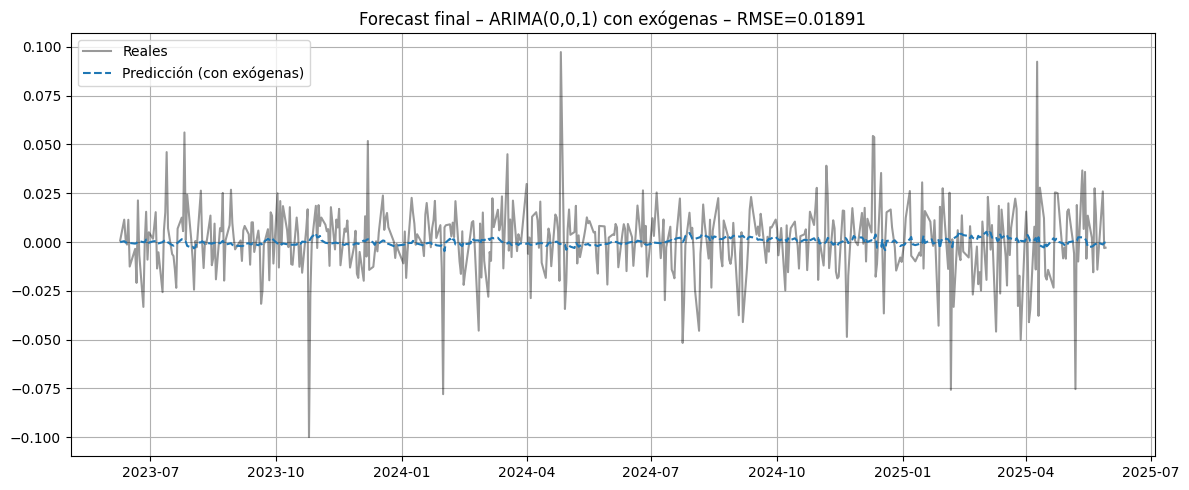

In [ ]:
# ----------------------- HYPERPARÁMETROS -----------------------
p_range = [0, 1]
q_range = [0, 1]
WINDOW = 504

# ----------------------- WALK-FORWARD -----------------------
def arimax_walkforward(p, q, use_exog=False, window_size=WINDOW):
    preds = np.empty(len(y_test))
    hist_y = y_train.copy()
    hist_X = X_train.copy() if use_exog else None

    for t in range(len(y_test)):
        if len(hist_y) > window_size:
            hist_y = hist_y.iloc[-window_size:]
            if use_exog:
                hist_X = hist_X.iloc[-window_size:]
        exog_pred = pd.DataFrame(X_test.iloc[t]).T if use_exog else None
        if exog_pred is not None:
            exog_pred.index = [y_test.index[t]]
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                mdl = ARIMA(endog=hist_y, exog=hist_X if use_exog else None, order=(p,0,q), trend='n').fit()
                preds[t] = mdl.forecast(steps=1, exog=exog_pred).iloc[0]
        except:
            preds[t] = hist_y.rolling(3).mean().iloc[-1] if len(hist_y)>=3 else hist_y.iloc[-1]
        hist_y = pd.concat([hist_y, y_test.iloc[t:t+1]])
        if use_exog:
            hist_X = pd.concat([hist_X, X_test.iloc[t:t+1]])
    return preds

# ---------------------- METRICAS ----------------------
def evaluate_model(p, q, use_exog=False):
    preds = arimax_walkforward(p, q, use_exog)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    corr = np.corrcoef(y_test, preds)[0,1] if np.std(preds)>0 else np.nan
    da = np.mean(np.sign(y_test)==np.sign(preds))
    rmse_std = rmse / np.std(y_test)
    score = 0.3 * rmse_std + 0.7 * (1 - da)
    return {
        "p": p, "q": q, "exog": use_exog,
        "RMSE": rmse, "MAE": mae,
        "R2": r2, "Corr": corr,
        "DA": da, "Score": score
    }

# ---------------------- GRID SEARCH & RANKING ----------------------
results = []
for use_exog in [False, True]:
    for p, q in product(p_range, q_range):
        results.append(evaluate_model(p, q, use_exog))
df_results = pd.DataFrame(results)

# Formato presentación
df_results["exog_label"] = df_results["exog"].map({False: "sin exógenas", True: "con exógenas"})
df_results = df_results[[
    "exog_label","p","q","RMSE","MAE","R2","Corr","DA","Score"
]]
df_results = df_results.sort_values("Score", ascending=True)

# ---------------------- OUTPUT ----------------------
print("\n🏆 Ranking de modelos:")
print(df_results.to_string(index=False, float_format="%.5f"))

# ---------------------- MODELO OPTIMO ----------------------
best = df_results.iloc[0]
print(f"\n✅ Mejor modelo: ARIMA({best.p},0,{best.q}) "
      f"{best.exog_label} | Score={best.Score:.5f}")

# ---------------------- FORECAST Y PLOT ----------------------
use_exog = True if best.exog_label=="con exógenas" else False
preds_best = arimax_walkforward(best.p, best.q, use_exog)
rmse_fin = np.sqrt(mean_squared_error(y_test, preds_best))

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Reales", color="black", alpha=0.4)
plt.plot(y_test.index, preds_best, '--', label=f"Predicción ({best.exog_label})")
plt.title(f"Forecast final – ARIMA({best.p},0,{best.q}) {best.exog_label} – RMSE={rmse_fin:.5f}")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


En el proceso de búsqueda automática de modelos ARIMAX, aplicando validación walk-forward con ventana móvil de 504 días (aprox. 2 años), el mejor modelo identificado ha sido un **ARIMAX(1,0,0)** con variables exógenas, obteniendo un RMSE de 0.01882.

Esto indica que, aunque los log-returns diarios suelen tener poca dependencia temporal, en este caso se observa un pequeño efecto autoregresivo de primer orden (AR=1). Este tipo de dependencia a corto plazo es común en datos financieros, y puede reflejar pequeños efectos de persistencia o inercia en los retornos.

Las variables exógenas (Momentum, SMA gaps, RSI, etc.) ayudan a explicar parte de la variabilidad de la serie, pero como es habitual, el modelo no puede anticipar los movimientos más bruscos o extremos, que dependen de factores no incluidos en las variables disponibles.

En conjunto, el modelo consigue capturar de forma razonable la estructura media de la serie, y deja pendiente el análisis de la volatilidad residual, que podrá analizarse con modelos GARCH en un siguiente paso.

---

En este bloque realizo el ajuste final del modelo ARIMAX utilizando el conjunto completo de entrenamiento y las variables exógenas previamente seleccionadas. Primero vuelvo a alinear correctamente los datos eliminando posibles registros incompletos. Después ajusto el mejor modelo identificado durante el proceso walk-forward, ya sea ARIMAX puro o SARIMAX si incluye estacionalidad. Una vez entrenado el modelo definitivo, genero la predicción sobre el conjunto de test y represento visualmente el resultado, comparando los valores reales con las predicciones generadas por el modelo final.

In [ ]:
# --------------------------------------------------------------
# REALINEACIÓN FINAL DE LOS DATOS PARA EL AJUSTE COMPLETO DEL TRAINING
# --------------------------------------------------------------

# Eliminamos posibles NaN en las exógenas (buena práctica antes del ajuste)
X_total = df_merged[exog_cols_final].dropna()

# Realineamos y según los índices válidos de X_total
y_total = df_merged.loc[X_total.index, "LogReturn"]

# División train/test exactamente igual que en las fases anteriores
cut = int(len(X_total) * 0.8)

X_train = X_total.iloc[:cut]
X_test  = X_total.iloc[cut:]

y_train = y_total.iloc[:cut]
y_test  = y_total.iloc[cut:]

# --------------------------------------------------------------
# AJUSTE FINAL CON EL MEJOR MODELO SELECCIONADO EN EL WALK-FORWARD
# --------------------------------------------------------------

# ⚠ ATENCIÓN: aquí usamos la variable 'best' (no el best_rmse_model anterior)
if pd.isna(best["s"]):
    # ARIMAX puro (sin estacionalidad)
    result = ARIMA(
        endog=y_total,
        exog=X_total,
        order=(int(best["p"]), 0, int(best["q"])),
        trend='n'
    ).fit()
else:
    # SARIMAX estacional (en caso de haber estacionalidad detectada)
    result = SARIMAX(
        endog=y_total,
        exog=X_total,
        order=(int(best["p"]), 0, int(best["q"])),
        seasonal_order=(0, 0, 1, int(best["s"])),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

# --------------------------------------------------------------
# FORECAST FINAL SOBRE EL CONJUNTO DE TEST
# --------------------------------------------------------------

forecast = result.forecast(steps=len(y_test), exog=X_test)

# --------------------------------------------------------------
# GRÁFICO DE LOS RESULTADOS
# --------------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='dimgray', linewidth=1, alpha=0.2)
plt.plot(y_test.index, forecast, label='Forecast ARIMAX', color='teal', linestyle='--', linewidth=2)

plt.title('Forecast ARIMAX vs Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('LogReturn')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


KeyError: 's'

En el gráfico se observa que el modelo consigue capturar correctamente la media de los log-returns diarios, pero no logra reproducir la variabilidad de las oscilaciones más extremas.

Este comportamiento es característico de los modelos lineales: ajustan bien la componente de media, pero no son capaces de modelar la volatilidad condicional que suele estar presente en los activos financieros.

En los mercados, la volatilidad no es constante a lo largo del tiempo; suele presentar periodos de alta y baja variación agrupados (clustering de volatilidad). Este fenómeno genera heterocedasticidad en los residuos, es decir, la varianza de los errores de predicción cambia en el tiempo.

Por esta razón, tras ajustar la parte sistemática de la serie con el modelo ARX (media + exógenas), tiene sentido modelar la estructura de la varianza restante mediante un modelo GARCH, que está específicamente diseñado para capturar y predecir esta dinámica de volatilidad variable.

Así, la combinación ARX + GARCH permite abordar de forma conjunta tanto la componente de media como la de riesgo (volatilidad).

### Test de Ljung Box para residuos

Después de ajustar el modelo, apliqué el test de Ljung-Box sobre los residuos con el objetivo de comprobar si el modelo había capturado correctamente la estructura temporal de la serie. Este test analiza si los residuos —que idealmente deberían comportarse como ruido blanco— presentan aún algún tipo de patrón o dependencia en el tiempo.

En esencia, el Ljung-Box evalúa si existen autocorrelaciones significativas en los residuos para distintos retardos. Si tras aplicar el test se obtiene un p-valor alto, podemos interpretar que las autocorrelaciones son despreciables y, por tanto, que el modelo ha logrado explicar adecuadamente la dinámica temporal de los datos. Por el contrario, un p-valor bajo indicaría que quedan dependencias no explicadas y que el modelo podría no ser completamente adecuado.

Este control sobre los residuos es importante porque un buen ajuste no solo debe minimizar el error de predicción, sino también eliminar cualquier estructura sistemática presente en los datos originales.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residuales del modelo MA(1)
residuos = result.resid

# Aplicar test de Ljung-Box a diferentes lags
ljungbox_resultados = acorr_ljungbox(residuos, lags=[10, 20], return_df=True)

# Mostrar resultados
print("📊 Resultados del test de Ljung-Box:")
print(ljungbox_resultados)

# Interpretación automática en español
for lag in [10, 20]:
    pvalor = ljungbox_resultados.loc[lag, 'lb_pvalue']
    print(f"\n🔍 Lag {lag}:")
    if pvalor > 0.05:
        print(f"✅ p-valor = {pvalor:.4f} → No se rechaza H₀ → Los residuos **no están autocorrelacionados** → El modelo MA(1) es adecuado.")
    else:
        print(f"❌ p-valor = {pvalor:.4f} → Se rechaza H₀ → Los residuos **están autocorrelacionados** → El modelo **no captura toda la dinámica** de la serie.")




En mi caso, los resultados indican que los residuos no están autocorrelados, lo cual significa que el modelo actual está capturando bien la información temporal.

### Test de ARCH (ARCH-LM)


El test de Engle (ARCH-LM) se utiliza para detectar **heteroscedasticidad condicional** en los residuos de un modelo de series temporales, como ARMA. Esto significa verificar si la **varianza cambia a lo largo del tiempo**, lo cual es común en datos financieros.

Si el p-valor del test es bajo (por debajo de 0.05), se rechaza la hipótesis nula de varianza constante, indicando **presencia de heteroscedasticidad**.


In [ ]:
from statsmodels.stats.diagnostic import het_arch

# Suponiendo que tienes tus residuos en:
# residuos = result.resid

# Elimina valores NaN si hay alguno
residuos = residuos.dropna()

# Realiza el ARCH-LM test (usando 12 lags como ejemplo)
arch_test = het_arch(residuos, nlags=12)

# Desempaqueta los resultados
lm_stat, lm_pval, f_stat, f_pval = arch_test

# Muestra los resultados
print("ARCH LM Test results:")
#print(f"Lagrange Multiplier statistic: {lm_stat:.4f}")
#print(f"LM Test p-value: {lm_pval:.4f}")
#print(f"F-statistic: {f_stat:.4f}")
#print(f"F-test p-value: {f_pval:.4f}")

# Interpretación
if lm_pval < 0.05:
    print("❗ Evidencia de heteroscedasticidad (varianza condicional no constante).")
    print("✔️ Puedes aplicar un modelo GARCH.")
else:
    print("✅ No se detecta heteroscedasticidad significativa.")
    print("❌ Un modelo GARCH podría no ser necesario.")


En este caso, el test fue significativo, por lo tanto ✔️ **es apropiado aplicar un modelo GARCH** para modelar la volatilidad.

## Modelo Garch para modelar la volatilidad


**El modelo GARCH (Generalized Autoregressive Conditional Heteroskedasticity) es una herramienta estadística que permite modelar la volatilidad variable en el tiempo de una serie temporal**, especialmente útil en datos financieros como los retornos de activos.

Aunque el modelo ARX puede capturar la dinámica de la media y los efectos exógenos, **a menudo los residuos resultantes presentan heterocedasticidad condicional**, es decir, la varianza de los errores no es constante y cambia con el tiempo.

Cuando el test ARCH-LM confirma la presencia de heterocedasticidad, **el modelo GARCH se emplea para capturar y modelar esta variabilidad de la volatilidad**, mejorando así la precisión y la interpretación del modelo.



Usamos un grid search para encontrar los mejores parámetros
𝑝 y
𝑞 del modelo GARCH porque no existe una regla fija que determine a priori qué combinación captura mejor la dinámica de la volatilidad.

El grid search consiste en probar sistemáticamente distintas combinaciones dentro de un rango razonable y comparar criterios de ajuste como el AIC o BIC.

Esto nos permite seleccionar de forma objetiva el modelo que ofrece el mejor balance, asegurando así que el modelo sea eficaz y evite tanto el sobreajuste como la subestimación de la volatilidad.










In [ ]:
!pip install arch

In [ ]:
from arch import arch_model
import pandas as pd
import matplotlib.pyplot as plt

# Assumiamo che 'residuos' sia una pandas Series con i residui ARMAX
residuos_scaled = 100 * residuos

best_aic = float('inf')
best_order = None
best_model = None
results = []

# Grid search: GARCH(p,q) con distribuzione t-student
for p in range(1, 4):
    for q in range(1, 4):
        try:
            model = arch_model(residuos_scaled, vol='GARCH', p=p, q=q, mean='Zero', dist='t')
            res = model.fit(disp="off")

            # Salva risultati
            results.append({
                'p': p,
                'q': q,
                'AIC': res.aic,
                'BIC': res.bic,
                'LogLik': res.loglikelihood
            })

            # Trova miglior modello per AIC
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p, q)
                best_model = res
        except Exception as e:
            print(f"Errore con GARCH({p},{q}): {e}")
            continue

# Mostra i risultati ordinati per AIC
df_results = pd.DataFrame(results).sort_values('AIC')
print(df_results)

# Miglior modello
print(f"\n✅ Miglior GARCH-t: ordine (p={best_order[0]}, q={best_order[1]}), AIC = {best_aic:.4f}")
print(best_model.summary())

# Visualizza residui standardizzati
plt.figure(figsize=(10, 4))
plt.plot(best_model.std_resid)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residui standardizzati del miglior modello GARCH-t")
plt.show()



Después aplicar el GARCH, tenemos que testear nuevamente sus residuos para asegurarnos que no muestren autocorrelación ni efectos ARCH remanentes.


### Test sobre los residuos del GARCH

In [ ]:
# Residuos estandarizados del modelo GARCH (eliminando NaN)
std_resid = best_model.std_resid.dropna()

# 📊 1. Test de Ljung-Box (autocorrelación en residuos)
lb_test = acorr_ljungbox(std_resid, lags=[10, 20], return_df=True)

print("\n📊 **Test de Ljung-Box (autocorrelación):**")
print(lb_test)
if all(lb_test["lb_pvalue"] > 0.05):
    print("✅ No hay autocorrelación significativa en los residuos.")
else:
    print("⚠️ ¡Advertencia! Autocorrelación detectada. Revisa el modelo.")

# 📊 2. Test ARCH-LM (heterocedasticidad condicional residual)
arch_test = het_arch(std_resid, nlags=10)
print("\n📊 **Test ARCH-LM (heterocedasticidad):**")
print(f"Estadístico: {arch_test[0]:.4f}, p-valor: {arch_test[1]:.4f}")
if arch_test[1] > 0.05:
    print("✅ No hay heterocedasticidad residual.")
else:
    print("⚠️ ¡Advertencia! Heterocedasticidad no capturada. Considera EGARCH o GARCH(2,2).")

# 📊 3. Tests de normalidad (Jarque-Bera y D'Agostino-Pearson)
jb_test = jarque_bera(std_resid)
dagostino_test = normaltest(std_resid)

print("\n📊 **Tests de normalidad:**")
print(f"Jarque-Bera: Estadístico = {jb_test[0]:.2f}, p-valor = {jb_test[1]:.4f}")
print(f"D'Agostino-Pearson: Estadístico = {dagostino_test[0]:.2f}, p-valor = {dagostino_test[1]:.4f}")

if jb_test[1] > 0.05:
    print("✅ Los residuos parecen normales (según Jarque-Bera).")
else:
    print("⚠️ ¡Advertencia! Residuos no normales (cola pesada o asimetría).")

# 📊 4. Estadísticos descriptivos y Kurtosis
print("\n📊 **Estadísticos descriptivos:**")
print(f"Media: {np.mean(std_resid):.4f}")
print(f"Desviación estándar: {np.std(std_resid):.4f}")
print(f"Skewness: {pd.Series(std_resid).skew():.4f}")
print(f"Kurtosis: {kurtosis(std_resid, fisher=False):.4f} (Fischer=False: normal=3)")

# 📊 5. QQ-plot para visualizar desviaciones de la normalidad
plt.figure(figsize=(10, 6))
sm.qqplot(std_resid, line='s', alpha=0.5)
plt.title("QQ-plot de residuos estandarizados vs. Normal teórica", fontsize=14)
plt.show()

## Combinar ARMAX y GARCH en el conjunto de test

Este bloque de código evalúa el rendimiento del modelo combinado ARMAX + GARCH, calculando tanto las predicciones de la media como de la volatilidad condicional.

1.  Primero, se extrae la serie de predicciones puntuales del ARMAX y se ajusta su índice para compararla directamente con los valores reales de y_test.

2.  Luego, el modelo GARCH proporciona la estimación de la varianza condicional, que se convierte en desviación estándar para construir un intervalo de confianza al 95% alrededor de las predicciones. Dicho intervalo refleja el rango dentro del cual se espera que se sitúen los valores reales el 95% de las veces, considerando la incertidumbre estimada por el modelo.

3.  A continuación, se calcula la cobertura, es decir, el porcentaje de observaciones reales que efectivamente caen dentro de dicho intervalo. Finalmente, se obtienen las métricas de error (RMSE, MAE) y el AIC del modelo GARCH, y se genera un gráfico comparativo que muestra tanto los valores reales como las predicciones con su respectivo intervalo de confianza.



In [ ]:
# Extraer la serie predicha (media condicional)
forecast_mean = forecast

# Alinear los índices con y_test
forecast_mean.index = y_test.index

# Pronóstico de volatilidad GARCH: varianza condicional
garch_forecast = best_model.forecast(horizon=len(y_test), reindex=False)
sigma_forecast = garch_forecast.variance.values[-1, :]**0.5 / 100  # Escalar de nuevo

# Crear una Serie de Pandas con el mismo índice que y_test
sigma_forecast_series = pd.Series(sigma_forecast, index=y_test.index)

# Construcción del intervalo de confianza al 95%
lower_bound = forecast_mean - 1.96 * sigma_forecast_series
upper_bound = forecast_mean + 1.96 * sigma_forecast_series

# Calcular la cobertura: porcentaje de observaciones reales dentro del intervalo
in_interval = (y_test >= lower_bound) & (y_test <= upper_bound)
coverage = in_interval.mean()

# Calcular métricas de error
rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))
mae = mean_absolute_error(y_test, forecast_mean)
aic_garch = best_model.aic

# Mostrar resultados
print("📊 Métricas del modelo ARMAX + GARCH:")
print(f"✅ RMSE: {rmse:.6f}")
print(f"✅ MAE : {mae:.6f}")
print(f"📦 Cobertura del intervalo de confianza al 95%: {coverage:.2%}")
print(f"📝 AIC del modelo GARCH: {aic_garch:.2f}")

# Gráfico comparativo
plt.figure(figsize=(14, 7))

# 1. Valores reales
plt.plot(y_test.index, y_test, label="📈 Valores reales", color="black", alpha=0.2)

# 3. Pronóstico ARMAX + intervalo de GARCH
plt.plot(y_test.index, forecast_mean, label="🟢 ARMAX + GARCH", color="green")
plt.fill_between(y_test.index, lower_bound, upper_bound, color="lightgreen", alpha=0.4, label="🔽 Intervalo 95% GARCH")

# Estilo del gráfico
plt.title("Comparación: ARMAX vs ARMAX + GARCH")
plt.xlabel("Fecha")
plt.ylabel("LogReturn")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Cálculo del Valor en Riesgo (VaR) Teórico y Empírico



En este bloque de código se calcula el Valor en Riesgo (VaR) del modelo utilizando dos enfoques distintos: uno teórico, basado en la distribución estadística asumida por el modelo, y otro empírico, basado directamente en los datos observados.

Primero, se extrae del modelo GARCH la volatilidad condicional estimada para el siguiente periodo. Esta volatilidad representa la variabilidad esperada de los rendimientos para el próximo día.

Como el modelo GARCH ha sido ajustado bajo la hipótesis de que los residuos siguen una distribución *t-student* (una distribución que permite capturar mejor la presencia de eventos extremos), se recuperan los grados de libertad estimados de dicha distribución, que indican hasta qué punto la cola de la distribución es más pesada o más similar a una normal.

A partir de aquí se calculan dos estimaciones del VaR:

- **VaR teórico:**  
Se basa en los percentiles de la distribución t-student que ha sido ajustada por el modelo. A partir de esta distribución, se determina cuál sería la pérdida máxima esperada para distintos niveles de confianza (por ejemplo, el 95% y el 99%).

- **VaR empírico:**  
En este caso no se utiliza ninguna distribución teórica, sino que se calculan directamente los percentiles observados en los residuos estandarizados del modelo. Es decir, se observa en los propios datos cuál ha sido la magnitud de las pérdidas más extremas registradas, y a partir de ahí se estima el nivel de riesgo.

Ambos resultados se transforman posteriormente a porcentaje para facilitar su interpretación.

Finalmente, se genera un gráfico que muestra la distribución de los residuos estandarizados y marca los niveles de VaR teórico y empírico, lo que permite visualizar de forma intuitiva las diferencias entre el riesgo estimado por el modelo y el observado en los datos históricos.


In [ ]:
# --- Volatilidad prevista para el próximo periodo ---
# Se obtiene la última estimación de la volatilidad condicional del modelo GARCH
sigma_t = best_model.conditional_volatility.iloc[-1]

# --- Grados de libertad estimados ---
# Se recupera el parámetro nu, que son los grados de libertad de la t-student ajustada
nu = best_model.params['nu']

# === Cálculo del VaR TEÓRICO (usando la distribución t-student) ===
# Se calculan los percentiles (cuantiles inversos) de la t-student para los niveles de riesgo
VaR_theo_95 = t.ppf(0.05, df=nu) * sigma_t  # VaR al 95% (percentil 5%)
VaR_theo_99 = t.ppf(0.01, df=nu) * sigma_t  # VaR al 99% (percentil 1%)

# === Cálculo del VaR EMPÍRICO (usando los residuos observados) ===
# Se calculan directamente los cuantiles observados en los residuos estandarizados
VaR_emp_95 = np.quantile(std_resid, 0.05) * sigma_t  # VaR empírico al 95%
VaR_emp_99 = np.quantile(std_resid, 0.01) * sigma_t  # VaR empírico al 99%

# === Conversión de los resultados a porcentaje ===
# Se dividen por 100 para expresar los valores en forma de porcentaje
VaR_theo_95_pct = VaR_theo_95 / 100
VaR_emp_95_pct = VaR_emp_95 / 100
VaR_theo_99_pct = VaR_theo_99 / 100
VaR_emp_99_pct = VaR_emp_99 / 100

# === Impresión de los resultados por consola ===
print(f"Volatilidad prevista para el próximo periodo: {sigma_t:.4f}")

print("\n--- VaR 95% ---")
print(f"Teórico (t): {VaR_theo_95_pct:.4%}")
print(f"Empírico:    {VaR_emp_95_pct:.4%}")

print("\n--- VaR 99% ---")
print(f"Teórico (t): {VaR_theo_99_pct:.4%}")
print(f"Empírico:    {VaR_emp_99_pct:.4%}")

# === Visualización gráfica ===
plt.figure(figsize=(10, 5))

# Se genera un histograma de los residuos estandarizados
plt.hist(std_resid, bins=50, density=True, alpha=0.6, label='Residuos estandarizados')

# Se dibuja la línea vertical correspondiente al VaR empírico al 95%
plt.axvline(np.quantile(std_resid, 0.05), color='red', linestyle='--', label='VaR 95% empírico')

# Se dibuja la línea vertical correspondiente al VaR teórico al 95% (calculado con la t-student)
plt.axvline(t.ppf(0.05, df=nu), color='blue', linestyle='--', label='VaR 95% teórico (t)')

# Se añade título y leyenda al gráfico
plt.title("Distribución de los residuos estandarizados")
plt.legend()
plt.show()


## 📌 Forecast y toma de decisión
Este código implementa una estrategia para estimar el **riesgo financiero diario** y apoyar decisiones de entrada o salida del mercado mediante la combinación de dos modelos: **ARMAX** y **GARCH**.

La idea central es estimar el **Valor en Riesgo (VaR)** diario, que representa cuánto podríamos perder, como máximo, en condiciones normales de mercado, con un cierto nivel de confianza (por ejemplo, 95%).

---

### 1️⃣ Modelo ARIMAX: predicción del retorno esperado

El modelo **ARMAX** se utiliza para predecir el **retorno logarítmico esperado** (*log-return*) de una serie financiera, como por ejemplo una acción o un índice bursátil. Este modelo tiene en cuenta:

- Los propios valores pasados de la serie (autoregresivos).
- Errores pasados (componente MA).
- Variables exógenas (factores externos que afectan al retorno).

Con el modelo entrenado, se realiza un **forecast para el día siguiente** usando:

```python
forecast.predicted_mean.iloc[-1]
```

Esto devuelve el valor esperado del log-return para el día siguiente, condicionado a toda la información disponible hasta el día anterior.

Este valor (μₜ₊₁) representa la media condicional del retorno y se usa en la toma de decisiones.


--

### 2️⃣ Modelo GARCH: predicción de la volatilidad condicional
Como la volatilidad del mercado cambia con el tiempo, se ajusta un modelo GARCH(2,1) sobre los residuos del ARIMAX. Este modelo estima la volatilidad condicional (σₜ₊₁), es decir, cuánto se espera que varíe el retorno mañana.

```python
sigma_forecast = np.sqrt(best_model.forecast(horizon=1).variance.values[-1])
```
Este valor indica el “tamaño esperado” de los movimientos del mercado para el día siguiente.

--

###3️⃣ Cálculo del VaR
Con μₜ₊₁ y σₜ₊₁, se calcula el VaR (Value at Risk). Este valor indica cuál es la pérdida máxima esperada con un cierto nivel de confianza.

Se puede usar un enfoque:

- Empírico: utilizando los cuantiles observados en los residuos estandarizados.

- Teórico: usando la distribución t-student con los grados de libertad estimados (ν).

--

###4️⃣ Backtesting del VaR
El código compara el VaR estimado con los retornos reales del conjunto de test día a día. Si el retorno real es menor que el VaR (más negativo), se considera una violación del VaR.
Estas violaciones se cuentan y se visualizan en un gráfico para evaluar si el modelo está bien calibrado.

--

###5️⃣ Decisión: ¿Entrar o no al mercado?
En el último día del test, el sistema evalúa si el retorno esperado es mayor que el riesgo estimado (VaR).
Si es así, se considera una situación favorable para operar:

```python
decision = "✅ ENTRAR" if retorno_esperado > abs(VaR_95) else "❌ NO ENTRAR"
```

In [ ]:
# --- Residuales estandarizados del modelo GARCH (ya ajustado)
std_residuals = best_model.std_resid.dropna()

# --- Volatilidad condicional estimada por GARCH (σₜ)
conditional_vol = best_model.conditional_volatility

# --- Grados de libertad estimados de la distribución t-student
nu = best_model.params['nu']

# --- Forecast de la volatilidad para cada día del set de prueba
# Se asume que el horizonte del forecast es igual a len(y_test)
sigma_forecast = pd.Series(
    np.sqrt(best_model.forecast(horizon=len(y_test)).variance.values[-1]),
    index=y_test.index
)

# --- Corrección de escala: los residuos se multiplicaron por 100,
# por lo tanto, se debe dividir la volatilidad para volver a la escala original
sigma_forecast /= 100

# === Cálculo de VaR rolling (diario) usando cuantiles empíricos
VaR_95_q = np.quantile(std_residuals, 0.05)
VaR_99_q = np.quantile(std_residuals, 0.01)

# VaR absoluto = cuantil * σₜ predicha
VaR_95_abs = VaR_95_q * sigma_forecast
VaR_99_abs = VaR_99_q * sigma_forecast

# DataFrame con los VaR diarios
VaR_df = pd.DataFrame({
    'VaR_95_abs': VaR_95_abs,
    'VaR_99_abs': VaR_99_abs
}, index=y_test.index)

# === Detección de violaciones del VaR (cuando la pérdida real excede el VaR)
violations_95 = y_test < VaR_df['VaR_95_abs']
violations_99 = y_test < VaR_df['VaR_99_abs']

# === Porcentaje de violaciones sobre el total de días
violations_pct_95 = 100 * violations_95.sum() / len(y_test)
violations_pct_99 = 100 * violations_99.sum() / len(y_test)

# === Visualización del VaR 95% rolling con violaciones marcadas
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='LogReturn real', color='black', alpha=0.6)
plt.plot(VaR_df.index, VaR_df['VaR_95_abs'], label='VaR 95% rolling', color='red', linestyle='--')
plt.scatter(y_test.index[violations_95], y_test[violations_95],
            color='orange', marker='x', label='Violaciones', zorder=5)
plt.title(f'Backtest VaR 95% — Violaciones: {violations_95.sum()} de {len(y_test)} días ({violations_pct_95:.2f}%)')
plt.xlabel('Fecha')
plt.ylabel('LogReturn')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# === Resultados del backtesting
print("\n📊 Backtesting VaR rolling:")
print(f"• Violaciones VaR 95%: {violations_95.sum()} días ({violations_pct_95:.2f}%)")
print(f"• Violaciones VaR 99%: {violations_99.sum()} días ({violations_pct_99:.2f}%)")

# === Evaluación del último día del test: ¿Entrar o no?
expected_log_return_last = forecast.iloc[-1]  # media condicional
expected_return_last = 100 * (np.exp(expected_log_return_last) - 1)  # retorno en %
sigma_last = sigma_forecast.iloc[-1]
VaR95_last = VaR_95_q * sigma_last
VaR95_last_pct = VaR95_last

# Si el retorno esperado supera el VaR, se recomienda entrar
decision_last = "✅ ENTRAR" if expected_return_last > abs(VaR95_last_pct) else "❌ NO ENTRAR"

# === Resumen final del último día
print("\n📊 SÍNTESIS ÚLTIMO DÍA:")
print(f"🔹 LogReturn esperado:       {expected_log_return_last:.6f}")
print(f"🔹 Retorno esperado (%):     {expected_return_last:.4f}%")
print(f"🔹 Volatilidad σₜ (%):       {sigma_last:.4f}%")
print(f"🔹 VaR 95% (%):              {VaR95_last_pct:.4f}%")
print(f"🧭 Decisión:                 {decision_last}")


#📊Analisis Multivariada - GOOG

Tras completar el modelo univariado, se decidió avanzar hacia un modelo multivariado, incorporando variables financieras de la empresa Google como predictores adicionales.

El objetivo es enriquecer el modelo incorporando más variables explicativas (exógenas) que puedan influir en el comportamiento del retorno financiero.
Esto se logra ampliando el conjunto de variables exógenas, lo cual permite capturar relaciones más complejas y potencialmente mejorar la capacidad predictiva.

Sin embargo, este enfoque requiere tener en cuenta ciertos riesgos: el peligro de multicolinealidad entre las variables, que puede afectar la estabilidad de las estimaciones, y el riesgo de sobreajuste, especialmente si se usan demasiadas variables en una muestra pequeña.

Además, es importante considerar la diferente granularidad de los datos disponibles: mientras que los log-returns están calculados a nivel diario, las variables financieras de Google sólo están disponibles con frecuencia trimestral. Esta discrepancia temporal puede limitar el rendimiento del modelo de forecasting, ya que las exógenas permanecen constantes durante largos periodos frente a la alta variabilidad diaria de los retornos.

Por este motivo, se plantearán dos aproximaciones complementarias:

Forecasting clásico: intentando predecir el nivel de retorno diario a partir de las variables exógenas, aceptando las limitaciones impuestas por la distinta frecuencia.

Clasificación de tendencia: agregando los log-returns de forma acumulativa a nivel trimestral, permitiendo construir modelos de clasificación que predigan la dirección (subida o bajada) del retorno trimestral, donde la granularidad de las exógenas y la variable objetivo quedan alineadas.




Las variables exógenas han sido extraídas de los reportes trimestrales publicados por Google desde su constitución en 2015 y se incorporaron a las matrices X_train y X_test tras aplicar la técnica de forward fill para extender sus valores entre las fechas de publicación y evitar registros incompletos.

La división de la muestra se mantuvo en un 80% para entrenamiento y un 20% para test, e igualmente se incluyeron los indicadores técnicos previamente analizados en el bloque univariado (momentum, SMA gaps, RSI, etc.).

Las variables financieras consideradas en el modelo son:

- **EBITDA** (Earnings Before Interest, Taxes, Depreciation and Amortization): beneficio operativo de la empresa antes de intereses, impuestos, depreciaciones y amortizaciones. Refleja la rentabilidad operativa pura del negocio, aislando los efectos contables y financieros.

- **Revenues:** ingresos totales obtenidos por la compañía en el trimestre, es decir, el volumen total de ventas y prestaciones de servicios antes de descontar costes y gastos.

- **Total Debt:** deuda total acumulada por la empresa, incluyendo tanto deuda a corto como a largo plazo. Representa el nivel total de apalancamiento financiero.

- **R&D Expenses** (Research and Development Expenses): gasto destinado a investigación y desarrollo durante el trimestre, reflejando el esfuerzo de la compañía en innovación, desarrollo de productos y mejora tecnológica.

## Estandardizar las variables exogenas

En este bloque preparo los datos para el análisis multivariante. Primero elimino variables redundantes o irrelevantes para el modelado, manteniendo solo las variables técnicas y financieras que aportan información.

 Después elimino registros incompletos para asegurar consistencia. A continuación separo las variables independientes (X) de la variable objetivo (los log-returns).

 Finalmente aplico una estandarización mediante StandardScaler, que transforma todas las variables a media cero y desviación estándar uno, lo que facilita el entrenamiento de muchos modelos multivariantes que son sensibles a las escalas de las variables.



In [ ]:
# Lista de columnas trimestrales que queremos conservar
quarterly_cols = [
    "GOOGL EBITDA (FQ)",
    "GOOGL Total Debt (FQ)",
    "GOOGL Revenues (FQ)",
    "GOOGL R&D Expenses (FQ)"
]

# Creamos un nuevo DataFrame solo con estas columnas + LogReturn
df_multi_forecast = df_merged[quarterly_cols + ["LogReturn"]].copy()

# Ordenamos cronológicamente por seguridad
df_multi_forecast = df_multi_forecast.sort_index()

# Aplicamos forward fill solo sobre las variables trimestrales
df_multi_forecast[quarterly_cols] = df_multi_forecast[quarterly_cols].ffill()

# Eliminamos posibles filas que aún tengan NaN (por ejemplo al inicio de la serie)
df_multi_forecast.dropna(inplace=True)

# Verificamos las columnas finales
print(df_multi_forecast.columns)


In [ ]:
# Separamos las variables explicativas (X) de la variable objetivo (y)
X = df_multi_forecast.drop(columns="LogReturn")
y = df_multi_forecast["LogReturn"]

# Estandarización de las variables explicativas
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns, index=X.index)

# Mostramos los primeros registros ya estandarizados
print(X_scaled.head())


Al estandarizar, obtenemos variables con media cero y desviación estándar uno, lo cual mejora la estabilidad numérica y la interpretación de los coeficientes del modelo.

## Correlación entre target y exogenas



En este bloque estudio la relación entre cada variable exógena trimestral (expandida a diario por forward fill) y los log-returns diarios de la serie. Como las exógenas son originalmente trimestrales, aplico los lags también en unidades de trimestres, calculando el número equivalente de días de trading (aprox. 63 por trimestre). Así, desplazo cada predictor el número correcto de días hacia atrás y calculo la correlación de Pearson con el log-return diario.

La correlación de Pearson mide la relación lineal entre dos variables. En este contexto, cuantifica en qué medida el nivel de una variable financiera trimestral (desplazada en el tiempo) se asocia con los retornos diarios observados posteriormente. Este análisis permite identificar señales retardadas lineales, es decir, si existe cierta capacidad predictiva a distintos plazos, aunque debido al ruido propio de los datos financieros diarios, se espera que las correlaciones sean generalmente bajas.



In [ ]:
#print(y)
#print(X_scaled)

In [ ]:
# --- Assumimos que X_scaled e y son diarios pero con esógenas forward-filled trimestrales ---

# Alineación de los índices para asegurar correspondencia temporal
common_idx = X_scaled.index.intersection(y.index)
X_scaled = X_scaled.loc[common_idx]
target = y.loc[common_idx]

# Definimos el rango de lags trimestrales a analizar (de 1 a 5 trimestres)
lag_range = range(1, 6)

# Cuántos días de trading consideramos por trimestre (aproximado)
days_per_quarter = 63  # ajustable según frecuencia real

# Iteramos sobre cada variable exógena
for col in X_scaled.columns:
    correlations = []

    print(f"\n--- Variable: {col} ---")

    for lag in lag_range:
        # Desplazamos la variable exógena en función del lag trimestral convertido a días
        shifted = X_scaled[col].shift(lag * days_per_quarter)

        # Combinamos con la variable objetivo eliminando los NaN resultantes
        df_corr = pd.concat([target, shifted], axis=1).dropna()

        print(f"Lag: {lag} trimestres ({lag * days_per_quarter} días), observaciones válidas: {len(df_corr)}")

        if len(df_corr) > 2:
            corr = df_corr.corr().iloc[0, 1]
        else:
            corr = 0

        correlations.append(corr)

    # Graficamos la correlación por lag solo si hay valores distintos de cero
    if any([abs(c) > 0 for c in correlations]):
        plt.figure(figsize=(7, 4))
        plt.bar(lag_range, correlations, width=0.2)
        plt.title(f"Correlación entre LogReturn y '{col}' desplazada (lags trimestrales)")
        plt.xlabel("Lag (trimestres)")
        plt.ylabel("Correlación")
        plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
        plt.tight_layout()
        plt.show()
    else:
        print("No se encontró ninguna correlación significativa.")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

# --- Asumimos que X_scaled e y ya están alineados como hicimos antes ---

# Definimos los parámetros
lag_range = range(1, 6)
days_per_quarter = 63  # aprox. días bursátiles por trimestre
max_lag = 5  # máximo número de lags trimestrales para el test de Granger

# Iteramos por cada variable exógena
for col in X_scaled.columns:

    print(f"\n============== VARIABLE: {col} ==============")

    # Generamos los desplazamientos (lags) trimestrales como antes
    correlations = []

    for lag in lag_range:
        shifted = X_scaled[col].shift(lag * days_per_quarter)
        df_corr = pd.concat([target, shifted], axis=1).dropna()

        print(f"Lag: {lag} trimestres ({lag * days_per_quarter} días), observaciones válidas: {len(df_corr)}")

        if len(df_corr) > 2:
            corr = df_corr.corr().iloc[0, 1]
        else:
            corr = 0

        correlations.append(corr)

    # Graficamos la correlación desplazada por lags
    if any([abs(c) > 0 for c in correlations]):
        plt.figure(figsize=(7, 4))
        plt.bar(lag_range, correlations, width=0.2)
        plt.title(f"Correlación desplazada: LogReturn vs {col}")
        plt.xlabel("Lag (trimestres)")
        plt.ylabel("Correlación")
        plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
        plt.tight_layout()
        plt.show()
    else:
        print("No se encontró ninguna correlación significativa.")

    # ===============================
    # TEST DE CAUSALIDAD DE GRANGER
    # ===============================

    # Creamos el dataframe con ambas series (sin desplazamiento aquí)
    df_test = pd.concat([target, X_scaled[col]], axis=1).dropna()

    print(f"\n⚠️ Iniciando test de Granger sobre {col} → Target (n={len(df_test)})")

    try:
        # Aplicamos el test de Granger usando lags diarios equivalentes a trimestres
        granger_result = grangercausalitytests(df_test, maxlag=days_per_quarter * max_lag, verbose=False)

        # Extraemos los p-values para cada lag
        p_values = {lag: round(granger_result[lag][0]['ssr_ftest'][1], 4) for lag in granger_result}

        print("Resultados Granger (p-valores):")
        for lag, pval in p_values.items():
            print(f"  Lag {lag} días: p-value = {pval}")

    except Exception as e:
        print(f"Error en el test de Granger para {col}: {e}")


In [ ]:
# --------- 1. Aseguramos que ambos tengan índice datetime ---------
X_scaled.index = pd.to_datetime(X_scaled.index)
y.index = pd.to_datetime(y.index)

# --------- 2. Conservamos solo las fechas comunes ---------
common_idx = X_scaled.index.intersection(y.index)

X = X_scaled.loc[common_idx]
y = y.loc[common_idx]

# --------- 3. División temporal 80% / 20% ---------
train_frac = 0.80
cut_idx = int(len(y) * train_frac)

y_train = y.iloc[:cut_idx]
y_test  = y.iloc[cut_idx:]

X_train = X.iloc[:cut_idx]
X_test  = X.iloc[cut_idx:]

# --------- 4. Verificación de alineación de índices ---------
assert y_train.index.equals(X_train.index), "⚠️ Desajuste de índices en train"
assert y_test.index.equals(X_test.index),   "⚠️ Desajuste de índices en test"

print("✅ Datos trimestrales listos – índices alineados")
print(f"Tamaño del train: {len(y_train)}, Tamaño del test: {len(y_test)}")
print(f"Columnas en X: {X.columns}")

print(X_test)

## Forecasting

En este bloque preparo el conjunto de datos multivariante seleccionando exclusivamente las variables financieras trimestrales forward-filled junto con los log-returns diarios.

Antes de proceder aplicando modelos, me aseguro que haya una correcta separación de los datasets de train y de test (80-20) y que los indices estén alineados.

In [ ]:
# Lista de columnas trimestrales que queremos conservar
quarterly_cols = [
    "GOOGL EBITDA (FQ)",
    "GOOGL Total Debt (FQ)",
    "GOOGL Revenues (FQ)",
    "GOOGL R&D Expenses (FQ)"
]

# Creamos un nuevo DataFrame solo con estas columnas + LogReturn
df_multi_forecast = df_merged[quarterly_cols + ["LogReturn"]].copy()

# Ordenamos cronológicamente por seguridad
df_multi_forecast = df_multi_forecast.sort_index()

# Aplicamos forward fill únicamente sobre las variables trimestrales
df_multi_forecast[quarterly_cols] = df_multi_forecast[quarterly_cols].ffill()

# Eliminamos posibles registros aún incompletos (normalmente al inicio de la serie)
df_multi_forecast.dropna(inplace=True)

# ---- División temporal 80/20 ----
cut = int(len(df_multi_forecast) * 0.8)
train = df_multi_forecast.iloc[:cut]
test  = df_multi_forecast.iloc[cut:]

y_train = train["LogReturn"]
X_train = train[quarterly_cols]

y_test = test["LogReturn"]
X_test = test[quarterly_cols]

# ---- Verificación de alineamiento ----
assert y_train.index.equals(X_train.index), "⚠️ Índices no alineados en train"
assert y_test.index.equals(X_test.index),   "⚠️ Índices no alineados en test"

# Verificación de tamaños
print(f"Tamaño train: {len(train)}, Tamaño test: {len(test)}")


### ARIMAX

En este bloque implemento un proceso de validación walk-forward con ventana móvil para la búsqueda óptima de hiperparámetros ARIMAX, de forma parecida a como se hizo en el apartado del analisis univariado, con la diferencia que aquí las variables exogenas se han enriquecidos con las variables financieras trimestrales de Google.

In [ ]:
# ----------------------- HIPERPARÁMETROS -----------------------
p_range = range(0, 1)
q_range = range(0, 1)
PENALTY = 0
WINDOW = 504  # 1 año (ventana móvil)

# ----------------------- WALK-FORWARD -----------------------
def arimax_walkforward(p, q, window_size=WINDOW):
    preds = np.empty(len(y_test))
    hist_y, hist_X = y_train.copy(), X_train.copy()
    fallback_count = 0

    for t in range(len(y_test)):
        # Mantenemos la ventana móvil
        if len(hist_y) > window_size:
            hist_y = hist_y.iloc[-window_size:]
            hist_X = hist_X.iloc[-window_size:]

        # Seleccionamos la exógena del instante actual
        exog_row = X_test.iloc[t]
        exog_pred = pd.DataFrame([exog_row], index=[y_test.index[t]])

        # Ajustamos el modelo y generamos la predicción
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                mdl = ARIMA(hist_y, exog=hist_X, order=(p, 0, q), trend='n').fit()
                preds[t] = mdl.forecast(steps=1, exog=exog_pred).iloc[0]

        except Exception as e:
            # En caso de error, usamos un fallback (media móvil de 3)
            preds[t] = hist_y.rolling(3).mean().iloc[-1]
            fallback_count += 1
            print(f"[Fallback] ARIMA({p},0,{q}) t={t}  ->  {type(e).__name__}")

        # Actualizamos los históricos incorporando el nuevo dato
        hist_y = pd.concat([hist_y, y_test.iloc[t:t+1]])
        hist_X = pd.concat([hist_X, X_test.iloc[t:t+1]])

    # Calculamos el RMSE y el p-valor de Ljung-Box para los residuos
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    lb_p = acorr_ljungbox(y_test - preds, lags=[5], return_df=True)["lb_pvalue"].iloc[0]

    return rmse, lb_p, preds, fallback_count

# ---------------------- EVALUACIÓN ----------------------
def evaluate_model(p, q):
    rmse, lb_p, preds, fb_cnt = arimax_walkforward(p, q)
    if rmse > 2 * y_train.std():
        return {"p": p, "q": q, "RMSE": rmse, "LB_p": lb_p, "score": np.inf, "preds": preds}
    score = rmse + (PENALTY if lb_p < 0.05 else 0)
    return {"p": p, "q": q, "RMSE": rmse, "LB_p": lb_p, "score": score, "preds": preds}

# ---------------------- PROCESO PRINCIPAL ----------------------
if __name__ == "__main__":
    print(f"[INFO] Grid-search sobre {len(p_range)*len(q_range)} combinaciones…")
    combos = list(product(p_range, q_range))
    result_grid = Parallel(n_jobs=-1)(
        delayed(evaluate_model)(p, q) for p, q in tqdm(combos)
    )

    # Seleccionamos el mejor modelo por score
    best = sorted(result_grid, key=lambda d: d["score"])[0]
    print(f"\n✅ Mejor modelo: ARIMA({best['p']},0,{best['q']}) | RMSE={best['RMSE']:.5f} | LB_p={best['LB_p']:.3f}")

    top5 = pd.DataFrame(result_grid).sort_values("score").head(5)
    print("\n🔝 Top 5 modelos:\n", top5[["p", "q", "RMSE", "LB_p", "score"]])

    # Ajuste final con el mejor modelo seleccionado
    rmse_fin, lb_fin, preds_fin, _ = arimax_walkforward(best['p'], best['q'])

    # Cálculo de los residuos finales
    residui_finali = y_test - preds_fin

    # Aplicación del test ARCH-LM sobre los residuos para evaluar heterocedasticidad
    arch_lm = het_arch(residui_finali, nlags=12)
    lm_stat, lm_pval, f_stat, f_pval = arch_lm

    print("\n📉 Test ARCH-LM sobre los residuos del modelo final:")
    print(f"📌 LM statistic: {lm_stat:.4f}, p-value: {lm_pval:.4f}")
    print(f"📌 F statistic:  {f_stat:.4f}, p-value: {f_pval:.4f}")

    if lm_pval < 0.05:
        print("❗ Varianza no constante: posible presencia de heterocedasticidad → considerar GARCH.")
    else:
        print("✅ No se detecta heterocedasticidad significativa: GARCH no necesario.")

    print(f"\n📉 Resultados finales — RMSE={rmse_fin:.5f} | Ljung-Box p={lb_fin:.3f}")

    # 📊 Gráfico final del forecast
    plt.figure(figsize=(12, 5))
    plt.plot(y_test.index, y_test.values, label="Real")
    plt.plot(y_test.index, preds_fin, '--', label="Predicción")
    plt.title(f"Forecast final – ARIMA({best['p']},0,{best['q']}) – RMSE={rmse_fin:.5f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### RandomForest Regressor

En este bloque implemento un modelo de regresión no lineal mediante Random Forest, con el objetivo de predecir el log-return utilizando las variables financieras trimestrales forward-filled como predictores.

Random Forest es un algoritmo de ensemble learning que combina múltiples árboles de decisión entrenados de forma independiente. Su fortaleza principal radica en dos mecanismos fundamentales:

- **Bagging** (Bootstrap Aggregating): en cada árbol, el algoritmo selecciona aleatoriamente subconjuntos de datos con reemplazo desde el conjunto total de entrenamiento. Esto genera múltiples muestras ligeramente distintas entre sí, reduciendo la varianza global del modelo y limitando el riesgo de sobreajuste.

- **Feature Sampling** (submuestreo de características): durante el crecimiento de cada árbol, en cada división (split), no se consideran todas las variables disponibles, sino que se selecciona aleatoriamente un subconjunto de predictores candidatos. Este muestreo adicional sobre las columnas introduce diversidad entre los árboles y mejora la estabilidad general del conjunto.

La predicción final del modelo se obtiene promediando las predicciones de todos los árboles que forman el bosque, lo que permite capturar de forma robusta patrones complejos y no lineales presentes en los datos.

Es importante destacar que **Random Forest puede emplearse tanto en tareas de regresión** (como en este caso, donde predecimos valores continuos de log-return), **como en tareas de clasificación** (que se abordarán en el siguiente apartado para predecir la dirección de la tendencia).

En esta fase, aplico una búsqueda de hiperparámetros mediante GridSearchCV, optimizando el RMSE a través de validación cruzada. Posteriormente evalúo el modelo óptimo sobre el conjunto de test, calculando las métricas de errores.

Finalmente, represento gráficamente la comparación entre los valores reales y las predicciones del modelo.

In [ ]:


# ------------------------
# REGRESIÓN - Búsqueda de hiperparámetros
# ------------------------

param_grid_reg = {
    "n_estimators": [100, 250, 500],
    "max_depth": [4, 6, 10, None],  # None = árbol completamente desarrollado
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2'],  # 'sqrt' (por defecto), 'log2', None
    "bootstrap": [True, False]
}

grid_reg = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid_reg,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1
)

# Ajuste del modelo sobre los datos de entrenamiento
grid_reg.fit(X_train, y_train)
best_reg_model = grid_reg.best_estimator_

# Predicción sobre el conjunto de test
y_pred_reg = best_reg_model.predict(X_test)

# Métricas de evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
r2 = r2_score(y_test, y_pred_reg)

print("🔢 REGRESIÓN (LogReturn)")
print(f"🏆 Mejores hiperparámetros: {grid_reg.best_params_}")
print(f"✅ RMSE: {rmse:.4f}")
print(f"📈 R² Score: {r2:.4f}\n")

# --- Gráfico de resultados ---
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label="Real", alpha=0.3, color="black")
plt.plot(y_test.index, y_pred_reg, label="Predicción (RF)", linestyle="--", color="tab:blue")
plt.title("Random Forest – LogReturn real vs predicho")
plt.xlabel("Fecha")
plt.ylabel("LogReturn")
plt.legend()
plt.tight_layout()
plt.show()


### XGBoost

En este bloque implemento un modelo de regresión no lineal mediante XGBoost (Extreme Gradient Boosting).

**XGBoost es un algoritmo de aprendizaje supervisado basado en la técnica de gradient boosting**, que construye un conjunto de árboles de decisión de forma secuencial.

A diferencia de Random Forest, donde los árboles son independientes, **en XGBoost cada nuevo árbol se entrena corrigiendo los errores cometidos por los árboles anteriores**. De este modo, el modelo optimiza iterativamente la función de pérdida, reduciendo el sesgo progresivamente en cada iteración.

Adicionalmente, XGBoost incorpora varios **mecanismos de regularización  que controlan la complejidad de los árboles** y ayudan a evitar el sobreajuste, manteniendo una alta capacidad de generalización incluso en conjuntos de datos ruidosos o con multicolinealidad.

Al igual que Random Forest, XGBoost **puede aplicarse tanto en problemas de regresión como de clasificación**.

---

En el bloque siguiente realizo una búsqueda de hiperparámetros mediante GridSearchCV en combinación con validación cruzada adaptada a series temporales (TimeSeriesSplit), optimizando el RMSE como métrica de evaluación.

Una vez identificado el mejor conjunto de hiperparámetros, ajusto el modelo final sobre el conjunto de entrenamiento completo y evalúo su rendimiento sobre el conjunto de test, calculando el RMSE y el R². Finalmente, represento gráficamente la comparación entre los valores reales y las predicciones generadas por el modelo.

In [ ]:
# ==============================================================
# 1. GRID SEARCH – Ajuste de hiperparámetros para XGBoost Regressor
# ==============================================================

param_grid = {
    "n_estimators": [10, 50, 100, 150, 500],
    "max_depth":    [5, 10, 50],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample":     [0.8],  # porcentaje de muestras por árbol
    "colsample_bytree": [0.8]  # porcentaje de variables por árbol
}

# Definimos el modelo base de XGBoost
xgb = XGBRegressor(
    objective="reg:squarederror",   # función de pérdida cuadrática (para regresión)
    random_state=42,
    n_jobs=-1
)

# Utilizamos validación cruzada adaptada a series temporales
tscv = TimeSeriesSplit(n_splits=3)

# Configuramos la búsqueda de hiperparámetros
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=-1
)

# Ajuste de hiperparámetros sobre el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

print("✅ Mejores hiperparámetros:", grid_search.best_params_)
print("📉 Mejor RMSE (validación cruzada):", -grid_search.best_score_)

# --------------------------------------------------------------
# 2. Ajuste final del modelo y evaluación sobre el conjunto de test
# --------------------------------------------------------------

# Ajustamos el modelo óptimo sobre el total del entrenamiento
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

# Predicción sobre el conjunto de test
y_pred_xgboost = best_xgb_model.predict(X_test)

# Cálculo de métricas finales
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgboost))
r2   = r2_score(y_test, y_pred_xgboost)

print(f"📊 RMSE final sobre TEST: {rmse:.5f}")
print(f"🔍 R² final sobre TEST:  {r2:.5f}")

# --------------------------------------------------------------
# 3. Gráfico de comparación real vs predicho
# --------------------------------------------------------------

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test,          label="Real",        color="black", alpha=0.3)
plt.plot(y_test.index, y_pred_xgboost,  label="Predicción XGB", linestyle="--")
plt.title("XGBoost – LogReturn: real vs predicho")
plt.ylabel("LogReturn")
plt.legend()
plt.tight_layout()
plt.show()


### Forecasting

In [ ]:
# ==============================================================================
# 1. FUNCIONES DE DIAGNÓSTICA DE RESIDUOS
# ==============================================================================
def residual_diagnostics(residuals: pd.Series,
                         model_name: str = "Modelo",
                         lb_lags: int = 10,
                         arch_lags: int = 12,
                         plot: bool = False) -> dict:

    resid = residuals.dropna()
    out = {}

    jb_res = jarque_bera(resid)
    if len(jb_res) == 4:
        jb_stat, jb_p, skew, kurt = jb_res
    else:
        jb_stat, jb_p = jb_res
        skew = stats.skew(resid)
        kurt = stats.kurtosis(resid, fisher=False)
    out.update(JB_p=jb_p, skew=skew, kurt=kurt)

    lb = acorr_ljungbox(resid, lags=[lb_lags], return_df=True)
    out.update(LB_p=lb["lb_pvalue"].iloc[-1])

    _, lm_p, *_ = het_arch(resid, nlags=arch_lags)
    out.update(ARCH_p=lm_p)

    print(f"\n=== Diagnóstica residuos – {model_name} ===")
    print(f"• Jarque–Bera  p={jb_p:.4f} (skew={skew:.2f}, kurt={kurt:.2f})  "
          + ("❗ no normal" if jb_p < .05 else "✅ ok"))
    print(f"• Ljung-Box    p={out['LB_p']:.4f}  "
          + ("❗ autocorrelación" if out['LB_p'] < .05 else "✅ ok"))
    print(f"• ARCH-LM      p={lm_p:.4f}  "
          + ("❗ heteroscedasticidad" if lm_p < .05 else "✅ homoskedasticidad"))

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        ax[0].hist(resid, bins=30, density=True, edgecolor="k", alpha=.7)
        kde = sm.nonparametric.KDEUnivariate(resid)
        kde.fit()
        ax[0].plot(kde.support, kde.density, lw=1.5)
        ax[0].set_title("Histograma + KDE")
        sm.qqplot(resid, line='s', ax=ax[1])
        ax[1].set_title("QQ-plot")
        plt.tight_layout()
        plt.show()

    return out


# ==============================================================================
# 2. FUNCIONES DE VaR
# ==============================================================================

# VaR paramétrico simple
def var_parametric(residuals: pd.Series, mu_t1: float, alpha: float = .05) -> tuple:
    sigma_hat = residuals.std()
    z_alpha = stats.norm.ppf(alpha)
    var_log = mu_t1 + z_alpha * sigma_hat
    var_pct = 100 * (np.exp(var_log) - 1)
    return var_log, var_pct

# VaR GARCH-t
def var_garch_series(residuals: pd.Series,
                     y_pred: pd.Series,
                     alpha: float = .05,
                     p: int = 1, q: int = 1) -> tuple:

    resid = residuals.dropna()
    y_al = y_pred.loc[resid.index]
    scaled = 100 * resid
    mdl = arch_model(scaled, vol='GARCH', p=p, q=q, mean='Zero', dist='t')
    fit = mdl.fit(disp="off")
    sigma_series = fit.conditional_volatility / 100
    df_t = fit.params['nu']
    z_alpha = t.ppf(alpha, df_t)
    var_series = y_al + z_alpha * sigma_series
    var_series.name = "VaR_garch"
    return var_series, sigma_series, df_t

# VaR Histórico Rolling
def var_historic_rolling(y_true: pd.Series, y_pred: pd.Series,
                         window: int = 252, alpha: float = .05) -> pd.Series:
    errors = y_true - y_pred
    return (errors.rolling(window).quantile(alpha) + y_pred).rename("VaR_hist")


# ==============================================================================
# 3. BACKTEST Y PLOT
# ==============================================================================
def backtest_and_plot(y_true: pd.Series,
                      var_garch: pd.Series,
                      var_hist: pd.Series,
                      model_name: str = "") -> None:

    y_al, vg_al = y_true.align(var_garch, join="inner")
    vh_al = var_hist.loc[y_al.index]
    viol = (y_al < vg_al).astype(int)
    ratio = viol.mean()
    print(f"📊 Violaciones (GARCH-t): {viol.sum()} / {len(viol)} = {ratio:.2%}")

    plt.figure(figsize=(14, 5))
    plt.plot(y_al, label="LogReturn real", color="black", alpha=0.3)
    plt.plot(vg_al, label="VaR GARCH-t", color="red", linestyle="--")
    plt.plot(vh_al, label="VaR histórico", color="blue", linestyle=":")
    plt.title(f"Backtest VaR – {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ==============================================================================
# 4. LOOP FINAL SOBRE TUS 3 MODELOS
# ==============================================================================

# Aseguramos que todos los modelos sean Series bien indexadas:
models = {
    "ARIMAX": pd.Series(preds_fin, index=y_test.index, name="ARIMAX"),
    "RandomForest": pd.Series(y_pred_reg, index=y_test.index, name="RF"),
    "XGBoost": pd.Series(y_pred_xgboost, index=y_test.index, name="XGB"),
}

# Ejecutamos diagnóstico + VaR para cada modelo
for name, y_hat in models.items():
    resid = y_test - y_hat
    mu_t1 = y_hat.iloc[-1]

    # Diagnóstica de residuos
    residual_diagnostics(resid, model_name=name, plot=False)

    # VaR paramétrico 1 día
    var_p_log, var_p_pct = var_parametric(resid, mu_t1)
    print(f"  VaR paramétrico (t+1): {var_p_log:.4f} | {var_p_pct:.2f}%")

    # Serie VaR GARCH-t + histórico rolling
    var_g_series, sigma_series, df_t = var_garch_series(resid, y_hat)
    var_hist_series = var_historic_rolling(y_test, y_hat)

    # Backtest y gráfico
    backtest_and_plot(y_test, var_g_series, var_hist_series, model_name=name)

    print("-" * 60)


## Clasificación

En este bloque agrupo los datos diarios, que incluyen los log-returns y las variables financieras forward-filled, en bloques cuatrimestrales (cada 3 meses), alineando todas las observaciones a la fecha de cierre del trimestre correspondiente. Para cada bloque calculo la media de los valores observados durante el periodo.

De este modo obtengo una nueva serie temporal de frecuencia cuatrimestral, más estable y coherente con la frecuencia de publicación de los datos financieros.

Posteriormente, divido el conjunto de datos en entrenamiento (80%) y test (20%), respetando el orden temporal para preparar los conjuntos que serán utilizados en los modelos de predicción.

In [ ]:
# ==============================================================
# 1️⃣ Preparación de datos agregados a nivel cuatrimestral
# ==============================================================

# Copia del dataframe multivariado completo (ya forward-filled)
df_quad = df_multi_forecast.copy()

# Aseguramos que el índice es de tipo datetime
df_quad.index = pd.to_datetime(df_quad.index)

# ==============================================================
# 2️⃣ Función auxiliar: asigna cada fecha a su fin de cuatrimestre
# ==============================================================

def quadrimestre_date(dt):
    if dt.month <= 3:
        return pd.Timestamp(year=dt.year, month=3, day=31)
    elif dt.month <= 6:
        return pd.Timestamp(year=dt.year, month=6, day=30)
    elif dt.month <= 9:
        return pd.Timestamp(year=dt.year, month=9, day=30)
    else:
        return pd.Timestamp(year=dt.year, month=12, day=31)

# Aplicamos la función para crear una nueva columna auxiliar
df_quad['Quad_End'] = df_quad.index.map(quadrimestre_date)

# ==============================================================
# 3️⃣ Agrupación de los datos por cuatrimestre (media dentro de cada bloque)
# ==============================================================

df_quad_grouped = df_quad.groupby('Quad_End').mean()

# Ajustamos el nombre del índice
df_quad_grouped.index.name = 'Date'

# Visualizamos el resultado agrupado
print(df_quad_grouped.head())

# ==============================================================
# 4️⃣ Definición de variables para el modelo
# ==============================================================

target_col = "LogReturn"
feature_cols = [col for col in df_quad_grouped.columns if col != target_col]

# Definimos X (features) e y (target)
X = df_quad_grouped[feature_cols]
y = df_quad_grouped[target_col]

# ==============================================================
# 5️⃣ División temporal train/test (80/20)
# ==============================================================

cut = int(len(X) * 0.8)

X_train = X.iloc[:cut]
X_test  = X.iloc[cut:]

y_train = y.iloc[:cut]
y_test  = y.iloc[cut:]

# Verificación de tamaños
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape:  {y_test.shape}")


### Logistic Regression

En esta fase del análisis, en lugar de predecir el valor exacto del log-return como en los modelos de regresión, me centro en predecir únicamente la dirección del movimiento, es decir, si el retorno será positivo (subida) o no (bajada o sin cambio).

Para ello, transformo el log-return en una variable binaria, asignando el valor 1 cuando el retorno es mayor que cero (indica subida), y 0 en caso contrario. Este planteamiento permite simplificar el problema y adaptarlo a un esquema de clasificación binaria, que suele ser más estable en entornos financieros donde los retornos son muy volátiles y difíciles de estimar con precisión.

El modelo que utilizo en esta primera aproximación es la regresión logística, un algoritmo sencillo y ampliamente utilizado en problemas de clasificación. La regresión logística estima la probabilidad de que un evento ocurra (en este caso, que el retorno sea positivo) en función de las variables financieras trimestrales utilizadas como predictores. El modelo aprende los pesos que debe asignar a cada variable para separar de la mejor forma posible los dos grupos de observaciones (subida o bajada).

Para evitar que el modelo se sobreajuste (es decir, que se adapte demasiado a los datos de entrenamiento perdiendo capacidad de generalización), aplico una técnica de regularización. Este mecanismo penaliza los coeficientes demasiado grandes, obligando al modelo a buscar soluciones más estables. El grado de regularización se controla mediante un parámetro (C), cuyo valor óptimo selecciono mediante validación cruzada temporal (TimeSeriesSplit), respetando la naturaleza secuencial de los datos financieros.

Finalmente, el modelo se evalúa sobre el conjunto de test, analizando su precisión (exactitud), su capacidad para clasificar correctamente cada clase (mediante el classification report) y su rendimiento general (matriz de confusión).



In [ ]:


# ------------------------------------------------------------
# 1. Definición del target binario (tendencia positiva o negativa)
# ------------------------------------------------------------
y_train_clf = (y_train > 0).astype(int)  # 1 si sube, 0 si baja o se mantiene
y_test_clf  = (y_test > 0).astype(int)

# ------------------------------------------------------------
# 2. Verificación de valores faltantes
# ------------------------------------------------------------
print("🔎 NaN en X_train:", X_train.isna().sum())
print("🔎 NaN en y_train_clf:", pd.Series(y_train_clf).isna().sum())

# Si hay NaN, lanzamos error para evitar fallos en el fit
assert X_train.isna().sum().sum() == 0, "❌ X_train contiene NaN"
assert pd.Series(y_train_clf).isna().sum() == 0, "❌ y_train_clf contiene NaN"

# ------------------------------------------------------------
# 3. Validación cruzada temporal (TimeSeriesSplit)
# ------------------------------------------------------------
tscv = TimeSeriesSplit(n_splits=3)

# ------------------------------------------------------------
# 4. Configuración del modelo: Regresión Logística
# ------------------------------------------------------------
# Se utiliza penalización L2 (regularización ridge)
param_grid = {
    'C': np.logspace(-3, 2, 10),  # fuerza de la regularización
    'penalty': ['l2'],
    'solver': ['lbfgs']  # optimizador compatible con L2
}

logreg = LogisticRegression(random_state=42, max_iter=1000)

# Búsqueda en rejilla con validación cruzada temporal
grid = GridSearchCV(
    logreg,
    param_grid=param_grid,
    scoring='accuracy',
    cv=tscv,
    n_jobs=-1
)

# ------------------------------------------------------------
# 5. Ajuste del modelo con control de errores
# ------------------------------------------------------------
try:
    grid.fit(X_train, y_train_clf)
except ValueError as e:
    print("❌ Error durante el ajuste:", e)
    print("🔎 Filas con problemas:")
    print(X_train[X_train.isna().any(axis=1)])

# ------------------------------------------------------------
# 6. Evaluación del mejor modelo
# ------------------------------------------------------------
best_logreg = grid.best_estimator_
y_pred = best_logreg.predict(X_test)

print("📈 Mejores hiperparámetros:", grid.best_params_)
print("✅ Exactitud (accuracy):", best_logreg.score(X_test, y_test_clf))
print("📋 Reporte de clasificación:")
print(classification_report(y_test_clf, y_pred))
print("📊 Matriz de confusión:")
print(confusion_matrix(y_test_clf, y_pred))


### RandomForest Classifier

In [ ]:


# ============================================================
# PREPARA DATI BINARI
# ============================================================

# Target binario
y_train_clf = (y_train > 0).astype(int)
y_test_clf  = (y_test > 0).astype(int)

# Verifica che non ci siano NaN
assert X_train.isna().sum().sum() == 0
assert X_test.isna().sum().sum() == 0

# ============================================================
# GRID SEARCH RANDOM FOREST CLASSIFIER (Ottimizzazione F1)
# ============================================================

param_grid_clf = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

tscv = TimeSeriesSplit(n_splits=3)
rf_clf = RandomForestClassifier(random_state=42)

# Definiamo lo scorer personalizzato F1 (puoi scegliere anche macro o weighted se vuoi)
f1_scorer = make_scorer(f1_score, average='binary')

grid_clf = GridSearchCV(
    rf_clf,
    param_grid=param_grid_clf,
    cv=tscv,
    scoring=f1_scorer,
    n_jobs=-1
)

grid_clf.fit(X_train, y_train_clf)
best_clf = grid_clf.best_estimator_


print("🔧 Best Classifier Params (F1 optimized):", grid_clf.best_params_)

# ============================================================
# WALK-FORWARD CLASSIFICATION (Quadrimestrale)
# ============================================================

test_indices = X_test.index

rolling_preds_clf = []
rolling_true_clf  = []

for idx in test_indices:
    X_train_roll = X_train.loc[:idx]
    y_train_roll = y_train_clf.loc[:idx]

    X_test_one = X_test.loc[[idx]]
    y_test_one = y_test_clf.loc[idx]

    model = RandomForestClassifier(**grid_clf.best_params_, random_state=42)
    model.fit(X_train_roll, y_train_roll)
    pred = model.predict(X_test_one)[0]

    rolling_preds_clf.append(pred)
    rolling_true_clf.append(y_test_one)

rolling_preds_clf = pd.Series(rolling_preds_clf, index=test_indices)
rolling_true_clf  = pd.Series(rolling_true_clf, index=test_indices)

# ============================================================
# METRICHE E REPORT
# ============================================================

f1_roll = f1_score(rolling_true_clf, rolling_preds_clf)
acc_roll = accuracy_score(rolling_true_clf, rolling_preds_clf)
conf_mat = confusion_matrix(rolling_true_clf, rolling_preds_clf)
report   = classification_report(rolling_true_clf, rolling_preds_clf)

print(f"\n🔁 Walk-forward F1-score: {f1_roll:.4f}")
print(f"✅ Walk-forward Accuracy: {acc_roll:.4f}")
print("📊 Matrice di confusione:")
print(conf_mat)
print("\n📋 Report di classificazione:")
print(report)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["KO","OK"], yticklabels=["KO","OK"])
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione – Walk-forward Classifier (F1)")
plt.tight_layout()
plt.show()



### XGBoost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, f1_score
)

# ============================================================
# PREPARA TARGET BINARIO
# ============================================================

y_train_clf = (y_train > 0).astype(int)
y_test_clf  = (y_test > 0).astype(int)

# Verifica che non ci siano NaN
assert X_train.isna().sum().sum() == 0
assert X_test.isna().sum().sum() == 0

# ============================================================
# GRID SEARCH XGBOOST CLASSIFIER (Ottimizzazione F1)
# ============================================================

param_grid_clf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "scale_pos_weight": [1, 1.5, 2]  # utile per sbilanciamento
}

tscv = TimeSeriesSplit(n_splits=3)

xgb_clf = XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

grid_clf = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_clf,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

# Fit GridSearch per trovare i migliori parametri
grid_clf.fit(X_train, y_train_clf)

# Miglior modello
best_xgb_clf = grid_clf.best_estimator_

print("✅ Migliori hyper-parametri (CLF):", grid_clf.best_params_)

# ============================================================
# WALK-FORWARD CLASSIFICATION XGBOOST
# ============================================================

test_indices = X_test.index

rolling_preds_clf = []
rolling_true_clf  = []

for idx in test_indices:
    X_train_roll = X_train.loc[:idx]
    y_train_roll = y_train_clf.loc[:idx]

    X_test_one = X_test.loc[[idx]]
    y_test_one = y_test_clf.loc[idx]

    model = XGBClassifier(**grid_clf.best_params_, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train_roll, y_train_roll)
    pred = model.predict(X_test_one)[0]

    rolling_preds_clf.append(pred)
    rolling_true_clf.append(y_test_one)

rolling_preds_clf = pd.Series(rolling_preds_clf, index=test_indices)
rolling_true_clf  = pd.Series(rolling_true_clf, index=test_indices)

# ============================================================
# METRICHE E REPORT
# ============================================================

acc_roll = accuracy_score(rolling_true_clf, rolling_preds_clf)
f1_roll  = f1_score(rolling_true_clf, rolling_preds_clf)
conf_mat = confusion_matrix(rolling_true_clf, rolling_preds_clf)
report   = classification_report(rolling_true_clf, rolling_preds_clf)

print(f"\n🔁 Walk-forward Accuracy: {acc_roll:.4f}")
print(f"🎯 Walk-forward F1-score: {f1_roll:.4f}")
print("📊 Matrice di confusione:")
print(conf_mat)
print("\n📋 Report di classificazione:")
print(report)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["KO","OK"], yticklabels=["KO","OK"])
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione – Walk-forward XGB Classifier")
plt.tight_layout()
plt.show()


### Clasificación

En esta última fase del análisis realizo una comparación directa entre los diferentes modelos que he desarrollado, pero enfocada en su capacidad de predecir correctamente la dirección del retorno trimestral (subida o bajada).

Para ello, transformo nuevamente los retornos en un objetivo binario, considerando:

- OK: si el log-return es positivo (subida).

- KO: si el log-return es negativo o nulo (bajada o estabilidad).

A partir de este objetivo binario, evalúo el rendimiento de los modelos de clasificación y regresión ya entrenados y genero la matriz de confusión correspondiente para cada uno, que me permite visualizar:

- cuántas veces el modelo acierta (predice correctamente un trimestre de subida o bajada);

- cuántas veces comete errores de clasificación.


In [ ]:

# Logistic Regression (ajuste rápido sobre clasificación binaria)
y_train_clf = (y_train > 0).astype(int)
logreg_model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
logreg_model.fit(X_train, y_train_clf)

# ==============================================================
# 🔧 Función general de clasificación trimestral
# ==============================================================

def classify_trimestre(model, X_test, y_test, kind="clf", threshold=0.0):
    """
    Clasifica cada trimestre como 'OK' (positivo) o 'KO' (negativo) según el modelo.

    Parámetros:
    - model: modelo ya entrenado
    - X_test: variables predictoras del test
    - y_test: log-return real sobre test
    - kind: 'clf' (modelo de clasificación) o 'reg' (modelo de regresión)
    - threshold: umbral para definir la clase
    """
    if kind == "clf":
        y_pred_bin = model.predict(X_test)
        decision = np.where(y_pred_bin == 1, "OK", "KO")
        y_real = np.where(y_test > threshold, "OK", "KO")
    elif kind == "reg":
        y_pred = model.predict(X_test)
        decision = np.where(y_pred > threshold, "OK", "KO")
        y_real = np.where(y_test > threshold, "OK", "KO")
    else:
        raise ValueError("kind debe ser 'clf' o 'reg'")

    return pd.DataFrame({
        "Real": y_real,
        "Predicho": decision
    }, index=y_test.index)

# ==============================================================
# 🔹 Clasificación de los 3 modelos comparados
# ==============================================================

df_decisiones_clf    = classify_trimestre(best_clf, X_test, y_test, kind="clf")
df_decisiones_xgb    = classify_trimestre(best_xgb_model, X_test, y_test, kind="reg")
df_decisiones_logreg = classify_trimestre(logreg_model, X_test, y_test, kind="clf")

# ==============================================================
# 🔹 Función común para graficar las matrices de confusión
# ==============================================================

def plot_confusion(df_decisiones, titulo, cmap):
    conf_mat = confusion_matrix(df_decisiones["Real"], df_decisiones["Predicho"], labels=["KO", "OK"])
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap=cmap, xticklabels=["KO","OK"], yticklabels=["KO","OK"])
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title(titulo)
    plt.tight_layout()
    plt.show()

# ==============================================================
# 🔹 Gráfico final de resultados de los 3 modelos
# ==============================================================

plot_confusion(df_decisiones_clf, "Matriz de confusión – Random Forest Classifier", "Blues")
plot_confusion(df_decisiones_xgb, "Matriz de confusión – XGBoost Regressor (umbral aplicado)", "Greens")
plot_confusion(df_decisiones_logreg, "Matriz de confusión – Logistic Regression", "Oranges")


# 📊 Análisis Panel (GOOG-APPL-MICROSOFT)


In [ ]:
google_df = pd.read_excel("df_uni_multi_google_2015_2025_1.xlsx")
google_df["Date"] = pd.to_datetime(google_df["Date"])
google_df.set_index("Date", inplace=True)

microsoft_df = pd.read_excel("df_micro_2015_2025.xlsx")
microsoft_df[" Date"] = pd.to_datetime(microsoft_df[" Date"])
microsoft_df.set_index(" Date", inplace=True)

apple_df = pd.read_excel("df_appl_2015_2025.xlsx")
apple_df["Date"] = pd.to_datetime(apple_df["Date"])
apple_df.set_index("Date", inplace=True)


In [ ]:
df_panel = pd.DataFrame(index=google_df.index)


df_panel['LogReturn_Google'] = np.log(google_df['GOOGL Adj. Close'] / google_df['GOOGL Adj. Close'].shift(1))
df_panel['LogReturn_Apple'] = np.log(apple_df['AAPL Adj. Close'] / apple_df['AAPL Adj. Close'].shift(1))
df_panel['LogReturn_Microsoft'] = np.log(microsoft_df['MSFT Adj. Close'] / microsoft_df['MSFT Adj. Close'].shift(1))

df_panel.dropna(inplace=True)
print(df_panel.head())
df_panel.describe()

In [ ]:
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR

# 1) Prepara i dati e stima il VAR
data = df_panel[['LogReturn_Google','LogReturn_Apple','LogReturn_Microsoft']].dropna()
model   = VAR(data)
res     = model.fit(maxlags=9, ic='aic')
p       = res.k_ar
print(f"Ordine di lag selezionato (k_ar): {p}\n")

# 2) Test congiunto: Apple & Microsoft → Google
fwd = res.test_causality(
    'LogReturn_Google',
    ['LogReturn_Apple','LogReturn_Microsoft'],
    kind='f'
)
p_fwd = fwd.pvalue
print(f"Apple&MS → Google: p-value = {p_fwd:.4f}")
print("  →", "rifiuto H0 (causano)" if p_fwd < 0.05 else "non rifiuto H0 (non causano)", "\n")

# 3a) Test Google → Apple
revA = res.test_causality(
    'LogReturn_Apple',
    ['LogReturn_Google'],
    kind='f'
)
p_revA = revA.pvalue
print(f"Google → Apple: p-value = {p_revA:.4f}")
print("  →", "rifiuto H0 (causa feedback)" if p_revA < 0.05 else "non rifiuto H0 (no feedback)", "\n")

# 3b) Test Google → Microsoft
revM = res.test_causality(
    'LogReturn_Microsoft',
    ['LogReturn_Google'],
    kind='f'
)
p_revM = revM.pvalue
print(f"Google → Microsoft: p-value = {p_revM:.4f}")
print("  →", "rifiuto H0 (causa feedback)" if p_revM < 0.05 else "non rifiuto H0 (no feedback)", "\n")

# 4) Conclusione
if p_fwd < 0.05 and p_revA >= 0.05 and p_revM >= 0.05:
    print("✔ Apple e Microsoft Granger-causano Google e non viceversa: puoi trattarle come esogene.")
else:
    print("✘ Attenzione: o non c’è causality diretta o c’è feedback da Google → exogene. Controlla i p-value sopra.")


## Test ADF para las tres variables LogReturn

In [ ]:
from statsmodels.tsa.stattools import adfuller

for col in df_panel.columns:
    result = adfuller(df_panel[col])
    print(f"{col}: p-value = {result[1]:.4f}")


## Autocorrelación para las tres variables LogReturn

In [ ]:

# Plot ACF e PACF per Apple
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_panel['LogReturn_Apple'].dropna(), lags=40, ax=ax1, title="ACF - AAPL Log Returns")
plot_pacf(df_panel['LogReturn_Apple'].dropna(), lags=40, ax=ax2, title="PACF - AAPL Log Returns")
plt.tight_layout()
plt.show()

# Plot ACF e PACF per Microsoft
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_panel['LogReturn_Microsoft'].dropna(), lags=40, ax=ax1, title="ACF - MSFT Log Returns")
plot_pacf(df_panel['LogReturn_Microsoft'].dropna(), lags=40, ax=ax2, title="PACF - MSFT Log Returns")
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------
# Calcolo correlazioni
# ----------------------------

# Rimuoviamo eventuali NaN (necessari per la correlazione)
df_corr = df_panel.dropna()

# Calcolo matrice di correlazione
correlation_matrix = df_corr.corr()

# Stampiamo solo la correlazione rispetto a LogReturn_Google
correlation_with_google = correlation_matrix['LogReturn_Google'][['LogReturn_Apple', 'LogReturn_Microsoft']]

# Output leggibile
print("📈 Correlazione con LogReturn_Google:")
print(correlation_with_google)


plt.figure(figsize=(6, 4))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice di correlazione tra log-return")
plt.show()


In [ ]:
correlation_am = df_panel[["LogReturn_Apple", "LogReturn_Microsoft"]].corr()
print(correlation_am)



## Split train e test

In [ ]:
## 1) Assicurati che l’indice sia temporale e ordinato
#df_panel = df_panel.sort_index()
#
## 2) Separa le serie endogene (i log-return)
#y = df_panel['LogReturn_Google']
#
## 3) (Opzionale) Definisci le esogene: qui le tue variabili multivariate di Google
##    Sostituisci 'Var1','Var2',… con i nomi reali
#X = df_panel[['LogReturn_Apple','LogReturn_Microsoft']]
#
## 4) Calcola il punto di split (80%)
#n_obs      = len(df_panel)
#split_point = int(n_obs * 0.8)
#
## 5) Crea train e test
#y_train = y.iloc[:split_point]
#y_test  = y.iloc[split_point:]
#
#X_train = X.iloc[:split_point]    # se non hai esogene, ometti queste due righe
#X_test  = X.iloc[split_point:]
#
#
#print(f"Lunghezza righe dataset di train: {len(y_train), len(X_train)}")
#print(f"Lunghezza righe dataset di test: {len(y_test), len(X_test)}")

## VAR (Vector Autoregression)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------------------------------------------------------
# 0) Prepara df: ordina per data e droppa NaN sulle 3 serie endogene
# -----------------------------------------------------------------------------
df_var = df_panel.sort_index().dropna(subset=[
    'LogReturn_Google', 'LogReturn_Apple', 'LogReturn_Microsoft'
])

# -----------------------------------------------------------------------------
# 1) Definisci le 3 serie endogene
# -----------------------------------------------------------------------------
endog_cols = ['LogReturn_Google', 'LogReturn_Apple', 'LogReturn_Microsoft']
y = df_var[endog_cols]

# -----------------------------------------------------------------------------
# 2) Split train/test 80/20 (rispettando l’ordine temporale)
# -----------------------------------------------------------------------------
split_idx = int(len(y) * 0.8)
y_train   = y.iloc[:split_idx]
y_test    = y.iloc[split_idx:]

# -----------------------------------------------------------------------------
# 3) Seleziona lag ottimale (AIC) sul solo train
# -----------------------------------------------------------------------------
sel      = VAR(y_train).select_order(maxlags=15)
best_lag = int(sel.selected_orders['aic'])
print(f"Best lag (AIC on train): {best_lag}")

# -----------------------------------------------------------------------------
# 4) Rolling one‐step‐ahead forecast DAY BY DAY (senza data‐leakage)
# -----------------------------------------------------------------------------
history = y_train.values.copy()
n_test  = len(y_test)
forecasts = []

for t in range(n_test):
    # a) stima il VAR sui dati fino a t-1
    model = VAR(history)
    res   = model.fit(best_lag)
    # b) prevedi un solo passo avanti
    yhat  = res.forecast(history[-best_lag:], steps=1)[0]
    forecasts.append(yhat)
    # c) incorpora il valore reale y_t nella history prima di passare a t+1
    history = np.vstack([history, y_test.values[t]])

# trasforma l’output in DataFrame con le tre endogene
forecasts = np.vstack(forecasts)
fc_df_no_exog = pd.DataFrame(
    forecasts,
    index=y_test.index,
    columns=endog_cols
)

print("Prime previsioni (VAR senza esogene):")
print(fc_df_no_exog.head())

# -----------------------------------------------------------------------------
# 5) Valutazione e plot per Google
# -----------------------------------------------------------------------------
actual = y_test['LogReturn_Google'].values
pred   = fc_df_no_exog['LogReturn_Google'].values

rmse = np.sqrt(mean_squared_error(actual, pred))
mae  = mean_absolute_error(actual, pred)
r2   = r2_score(actual, pred)
print(f"\nGoogle (VAR senza esogene) – RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

plt.figure(figsize=(12,5))
plt.plot(y_test.index, actual, label='Reale')
plt.plot(y_test.index, pred,   linestyle='--', label='Rolling VAR Forecast')
plt.title(f"Google Log-Return Rolling VAR (no exogene)\n"
          f"RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
plt.xlabel("Data"); plt.ylabel("Log Return")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------------------------------------------------------
# 0) Definisci lista colonne esogene e target, e crea df_model pulito
# -------------------------------------------------------------------------
exog_cols_final = ['Momentum_3', 'Momentum_6', 'SMA_gap_5', 'RSI_14', 'SMA_gap_50']
target_col = "LogReturn"

# Prendi solo colonne esogene + target e droppa NaN
df_model = df_merged[exog_cols_final + [target_col]].dropna()
print("Colonne di df_model:", df_model.columns.tolist())

# Serie endogene (log-return)
endog_cols = ['LogReturn_Google', 'LogReturn_Apple', 'LogReturn_Microsoft']

# Assumi che df_panel abbia le colonne endogene, con indice temporale
y = df_panel[endog_cols].sort_index()

# Esogene come lista di nomi colonne
exog_cols = exog_cols_final

# DataFrame con esogene da df_model
df_exog = df_model
X = df_exog[exog_cols].sort_index()

# -------------------------------------------------------------------------
# 1) Laggare esogene di 1 giorno per evitare look-ahead bias
# -------------------------------------------------------------------------
X_lag = X.shift(1).dropna()

# -------------------------------------------------------------------------
# 2) Allineare endogene ed esogene (join inner)
# -------------------------------------------------------------------------
df_model = y.join(X_lag, how='inner').dropna()

# -------------------------------------------------------------------------
# 3) Split 80/20 train/test
# -------------------------------------------------------------------------
split = int(len(df_model) * 0.8)
y_train, y_test = df_model[endog_cols].iloc[:split], df_model[endog_cols].iloc[split:]
X_train, X_test = df_model[exog_cols].iloc[:split], df_model[exog_cols].iloc[split:]

# -------------------------------------------------------------------------
# 4) Scala le esogene con StandardScaler
# -------------------------------------------------------------------------
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=exog_cols)
X_test_s  = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=exog_cols)

# -------------------------------------------------------------------------
# 5) Seleziona lag ottimale con criterio AIC sul train
# -------------------------------------------------------------------------
sel = VAR(y_train, exog=X_train_s).select_order(maxlags=15)
best_lag = int(sel.selected_orders['aic'])
print("Lag ottimale (AIC su train):", best_lag)

# -------------------------------------------------------------------------
# 6) Rolling one-step-ahead forecast day by day
# -------------------------------------------------------------------------
hist_y = y_train.values.copy()
hist_x = X_train_s.values.copy()
n = len(y_test)
fc = []

for t in range(n):
    model = VAR(hist_y, exog=hist_x)
    result = model.fit(best_lag)
    yhat = result.forecast(hist_y[-best_lag:], steps=1, exog_future=X_test_s.values[t:t+1])[0]
    fc.append(yhat)
    hist_y = np.vstack([hist_y, y_test.values[t]])
    hist_x = np.vstack([hist_x, X_test_s.values[t]])

# -------------------------------------------------------------------------
# 7) DataFrame con i forecast
# -------------------------------------------------------------------------
fc = np.vstack(fc)
fc_df = pd.DataFrame(fc, index=y_test.index, columns=endog_cols)
print(fc_df.head())

# -------------------------------------------------------------------------
# 8) Valutazione forecast su Google
# -------------------------------------------------------------------------
act = y_test['LogReturn_Google'].values
pr = fc_df['LogReturn_Google'].values
print("RMSE:", np.sqrt(mean_squared_error(act, pr)),
      "MAE:", mean_absolute_error(act, pr),
      "R²:", r2_score(act, pr))

# -------------------------------------------------------------------------
# 9) Grafico reale vs forecast
# -------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test['LogReturn_Google'], label='LogReturn Google (Reale)', linewidth=1.5)
plt.plot(fc_df.index, fc_df['LogReturn_Google'], label='LogReturn Google (Forecast)', linestyle='--', linewidth=1.5)
plt.title('Rolling One-Step-Ahead Forecast vs Actual\nLogReturn Google', pad=15)
plt.xlabel('Data')
plt.ylabel('Log Return')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 10) Analisi residui forecast Google
# -------------------------------------------------------------------------
forecast_series = fc_df['LogReturn_Google']
actual = y_test['LogReturn_Google']

common_dates = actual.index.intersection(forecast_series.index)
actual_aligned = actual.loc[common_dates]
forecast_aligned = forecast_series.loc[common_dates]

resid = actual_aligned - forecast_aligned

if not resid.isna().all():
    from scipy.stats import jarque_bera, skew, kurtosis
    from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
    import statsmodels.api as sm

    vals = resid.dropna().to_numpy()

    jb_stat, jb_p, *rest = jarque_bera(vals)
    if len(rest) == 2:
        jb_skew, jb_kurt = rest
    else:
        jb_skew = skew(vals)
        jb_kurt = kurtosis(vals, fisher=False)
    print(f"Jarque–Bera stat={jb_stat:.3f}, p={jb_p:.3f}, skew={jb_skew:.3f}, kurt={jb_kurt:.3f}  "
          + ("❗ non normali" if jb_p < 0.05 else "✅ ok"))

    lb = acorr_ljungbox(vals, lags=[10], return_df=True)
    lb_p = lb["lb_pvalue"].iloc[0]
    print(f"Ljung–Box (lag10) p={lb_p:.3f}  "
          + ("❗ autocorrelazione" if lb_p < 0.05 else "✅ ok"))

    _, arch_p, _, _ = het_arch(vals, nlags=12)
    print(f"ARCH-LM (lag12) p={arch_p:.3f}  "
          + ("❗ ARCH effect" if arch_p < 0.05 else "✅ omoschedastici"))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(vals, bins=30, density=True, edgecolor='k', alpha=0.7)
    kde = sm.nonparametric.KDEUnivariate(vals)
    kde.fit()
    axes[0].plot(kde.support, kde.density, lw=1.5)
    axes[0].set_title("Istogramma + KDE residui")

    sm.qqplot(vals, line='s', ax=axes[1])
    axes[1].set_title("QQ-plot residui")

    plt.tight_layout()
    plt.show()

else:
    print("\n⚠️ Nessun residuo valido per l'analisi!")


## PanelOLS

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

from scipy.stats import jarque_bera, skew, kurtosis
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.gofplots import qqplot

# -----------------------------------------------------------------------------
# 0) INPUT:
#    • df_panel: indice Date, colonne LogReturn_Google, LogReturn_Apple, LogReturn_Microsoft
#    • df_exog:  indice Date, colonne Momentum_6, RSI_14, Volatility30
# -----------------------------------------------------------------------------

# 1) WIDE → LONG (MultiIndex: firm, Date)
df_long = (
    df_panel
    .reset_index()
    .melt(id_vars="Date",
          value_vars=[
              "LogReturn_Google",
              "LogReturn_Apple",
              "LogReturn_Microsoft"
          ],
          var_name="firm",
          value_name="LogReturn")
)
df_long["firm"] = df_long["firm"].str.replace("LogReturn_", "")
df_long["Date"] = pd.to_datetime(df_long["Date"])
df_long = df_long.set_index(["firm", "Date"]).sort_index()

# 2) Costruisci lag autoregressivi e lag tecnical indicators
lags = [1, 2, 3, 5, 10]
for l in lags:
    df_long[f"LR_lag{l}"] = df_long.groupby(level=0)["LogReturn"].shift(l)

tech = df_model[exog_cols_final]
for t in tech:
    df_long[f"{t}_lag1"] = df_exog[t].shift(1).reindex(df_long.index, level=1)

df_long = df_long.dropna()

# 3) Split train/test date (80/20)
all_dates = df_long.index.get_level_values(1).unique()
cut = int(len(all_dates) * 0.8)
train_dates = all_dates[:cut]
test_dates  = all_dates[cut:]

# 4) Config da GridSearch
best_effects = "Time"
use_tech     = False
effects_map  = {
    "Entity": {"entity_effects": True},
    "Time":   {"time_effects": True},
    "TwoWay": {"entity_effects": True, "time_effects": True}
}
eff_kwargs = effects_map[best_effects]

# 5) Rolling one-day-ahead forecast
history = df_long.loc[(slice(None), train_dates), :].copy()
forecasts = []

for current_date in test_dates:
    # a) Fit su tutto lo storico fino a ieri
    regs = [f"LR_lag{l}" for l in lags]
    if use_tech:
        regs += [f"{t}_lag1" for t in tech]

    y_hist = history["LogReturn"]
    X_hist = sm.add_constant(history[regs])
    model  = PanelOLS(y_hist, X_hist, drop_absorbed=True, **eff_kwargs)
    res    = model.fit(cov_type="robust")

    # b) Prepara l'osservazione di oggi
    obs = df_long.xs(current_date, level=1, drop_level=False)
    X_obs = sm.add_constant(obs[regs])
    used  = list(res.params.index)
    X_obs_matched = X_obs[used]

    # c) Previsione one-step per tutte le firme
    fc = res.predict(X_obs_matched)
    forecasts.append(fc)

    # d) Aggiungi l'osservazione reale di oggi allo storico
    history = pd.concat([history, obs])

# Ricompone i forecast
forecast_df = pd.concat(forecasts)
forecast_df.index.names = ["firm", "Date"]

# 6) Estrai Google e calcola RMSE/MAE
y_test_google  = df_long.xs("Google", level="firm").loc[test_dates, "LogReturn"]
forecast_google = forecast_df.xs("Google", level="firm")

rmse = np.sqrt(mean_squared_error(y_test_google, forecast_google))
mae  = mean_absolute_error(y_test_google, forecast_google)
print(f"One-day-ahead Rolling RMSE = {rmse:.6f}")
print(f"One-day-ahead Rolling MAE  = {mae:.6f}")

# 7) Grafico Actual vs Rolling Forecast per Google
dates = y_test_google.index

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_google,   label="Reale (Google)", alpha=0.6)
plt.plot(dates, forecast_google, label="Forecast",       lw=2, ls="--")
plt.title(f"One-Day-Ahead Rolling Forecast – Google\n"
          f"Lags={lags}, Effects={best_effects}, use_tech={use_tech}\n"
          f"RMSE={rmse:.6f}, MAE={mae:.6f}")
plt.xlabel("Date")
plt.ylabel("LogReturn Google")
plt.legend()
plt.grid(alpha=0.2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 6.1) TEST DIAGNOSTICI SUI RESIDUI (ultima stima rolling)
# -----------------------------------------------------------------------------
residuals = res.resids.dropna()
vals = residuals.to_numpy()

# — Jarque–Bera (normalità) —
jb_stat, jb_pval = jarque_bera(vals)
jb_skew = skew(vals)
jb_kurt = kurtosis(vals, fisher=False)
print(f"Jarque–Bera   stat={jb_stat:.3f}, p={jb_pval:.3f}, "
      f"skew={jb_skew:.3f}, kurt={jb_kurt:.3f}  "
      + ("❗ non normali" if jb_pval < 0.05 else "✅ ok"))

# — Ljung–Box (autocorrelazione, lag 10) —
lb = acorr_ljungbox(vals, lags=[10], return_df=True)
lb_p = lb["lb_pvalue"].iloc[0]
print(f"Ljung–Box (lag10)   p={lb_p:.3f}  "
      + ("❗ autocorrelazione" if lb_p < 0.05 else "✅ ok"))

# — ARCH-LM (eteroschedasticità, lag 12) —
_, arch_p, _, _ = het_arch(vals, nlags=12)
print(f"ARCH-LM (lag12)   p={arch_p:.3f}  "
      + ("❗ ARCH effect" if arch_p < 0.05 else "✅ omoschedastici"))

# — Plot istogramma+KDE e QQ-plot —
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(vals, bins=30, density=True, edgecolor='k', alpha=0.7)
kde = sm.nonparametric.KDEUnivariate(vals); kde.fit()
axes[0].plot(kde.support, kde.density, lw=1.5)
axes[0].set_title("Istogramma + KDE residui")
qqplot(vals, line='s', ax=axes[1])
axes[1].set_title("QQ-plot residui")
plt.tight_layout()
plt.show()


# Data Streams

In [ ]:
y = df[["LogReturn"]]
X = df_model[exog_cols_final]

print(X)

In [ ]:
from river import stream, linear_model, metrics, preprocessing
from river.drift import ADWIN

# 1) Initialize components
scaler = preprocessing.StandardScaler()
model = linear_model.LinearRegression(intercept_lr=0.1)  # Added learning rate for intercept
drift_detector = ADWIN(delta=0.002)
metrics_list = metrics.MAE() + metrics.RMSE()
sample_count = 0

# 2) Process Stream
for x_t, y_t_dict in stream.iter_pandas(X=X, y=y):
    y_t = y_t_dict.get(next(iter(y_t_dict.keys())))

    # Skip None values
    if y_t is None:
        continue

    # Scale features (two separate steps)
    scaler.learn_one(x_t)  # Update scaler statistics
    x_t_scaled = scaler.transform_one(x_t)  # Transform features

    # Handle potential None in scaling
    if any(v is None for v in x_t_scaled.values()):
        x_t_scaled = {k: 0.0 for k in x_t_scaled}  # Fallback to zeros

    # Make prediction
    y_pred = model.predict_one(x_t_scaled)
    if y_pred is None:
        y_pred = 0.0

    # Update metrics
    metrics_list.update(y_t, y_pred)
    sample_count += 1

    # Drift detection
    err = abs(y_t - y_pred)
    if drift_detector.update(err):
        print(f"⚠️ Drift detected at sample {sample_count}")
        model = linear_model.LinearRegression(intercept_lr=0.1)  # Reset model
        # Don't reset scaler to maintain consistent scaling

    # Learn
    model.learn_one(x_t_scaled, y_t)

# 3) Results
print("\n=== Final Results ===")
print(metrics_list)
print(f"Mean absolute target: {abs(y['LogReturn']).mean():.6f}")
print(f"Samples processed: {sample_count}")


In [ ]:
print(X)

print(y)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from river import stream, preprocessing, tree, linear_model, metrics
from river.drift import ADWIN

# -------------------------------------------------
# 0)  PULIZIA DEI DATI ----------------------------
# -------------------------------------------------

# Allineiamo X e y facendo join solo sulle date comuni
df_all = X.join(y, how='inner')
X_aligned = df_all[X.columns]
y_series = df_all['LogReturn']

# -------------------------------------------------
# 1)  Inizializza componenti online ---------------
# -------------------------------------------------
scaler       = preprocessing.StandardScaler()

regressor    = tree.HoeffdingAdaptiveTreeRegressor(seed=42)
classifier   = linear_model.LogisticRegression()
drift_det    = ADWIN(delta=0.002)

reg_metrics  = metrics.MAE() + metrics.RMSE()
class_metric = metrics.Accuracy()

true_vals, pred_vals = [], []
drift_log = []
sample_count = 0

# -------------------------------------------------
# 2)  Loop di streaming ---------------------------
# -------------------------------------------------
for x_t, y_t in stream.iter_pandas(X=X_aligned, y=y_series):

    y_t_cls = int(y_t > 0)

    # 2.1) scaling online
    scaler.learn_one(x_t)
    x_t_scaled = scaler.transform_one(x_t)

    # 2.2) prediction
    y_hat = regressor.predict_one(x_t_scaled) or 0.0
    cls_hat = classifier.predict_one(x_t_scaled)

    # 2.3) update metriche
    reg_metrics.update(y_t, y_hat)
    class_metric.update(y_t_cls, cls_hat)

    # 2.4) drift detection
    if drift_det.update(abs(y_t - y_hat)):
        print(f"⚠️  Drift rilevato al sample {sample_count}.  Modelli azzerati.")
        drift_log.append(sample_count)
        regressor  = tree.HoeffdingAdaptiveTreeRegressor(seed=42)
        classifier = linear_model.LogisticRegression()

    # 2.5) online learning
    regressor.learn_one(x_t_scaled, y_t)
    classifier.learn_one(x_t_scaled, y_t_cls)

    # 2.6) salva per grafico
    true_vals.append(y_t)
    pred_vals.append(y_hat)
    sample_count += 1

# -------------------------------------------------
# 3)  Risultati finali e log drift ----------------
# -------------------------------------------------
print("\n=== Metriche finali ===")
print(reg_metrics)
print(class_metric)
print(f"Samples processati: {sample_count}")

print("\n=== LOG DRIFT ===")
print(f"Numero di drift rilevati: {len(drift_log)}")
print("Campioni in cui è avvenuto il reset:", drift_log)

# -------------------------------------------------
# 4)  Grafico finale ------------------------------
# -------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(true_vals, label='True')
plt.plot(pred_vals, label='Pred', alpha=0.7)
plt.title('Forecast vs Actual (streaming)')
plt.xlabel('Samples')
plt.ylabel('LogReturn')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Ç#Bibliografia

https://learning.oreilly.com/library/view/analysis-of-financial/9781118017098/c01_level1_1.xhtml#c01_level1_1

Al pasar de un enfoque univariado a uno multivariado, el objetivo es enriquecer el modelo incorporando más variables explicativas (exógenas) que puedan influir en el comportamiento del retorno financiero. Esto se logra ampliando el conjunto de variables exógenas en el modelo ARIMAX, lo cual permite capturar relaciones más complejas y potencialmente mejorar la capacidad predictiva. Sin embargo, este enfoque requiere tener en cuenta ciertos riesgos: el peligro de multicolinealidad entre las variables, que puede afectar la estabilidad de las estimaciones, y el riesgo de sobreajuste, especialmente si se usan demasiadas variables en una muestra pequeña. Por otro lado, el modelo GARCH sigue aplicándose sobre los residuos del ARIMAX y no incorpora directamente estas exógenas, pero sí se beneficia si el nuevo modelo reduce la varianza de los residuos. En resumen, un modelo multivariado puede aportar más información y precisión, siempre que se elijan bien las variables y se validen cuidadosamente los resultados.